In [3]:
import json
import logging
from tqdm import tqdm

from llamafactory.chat import ChatModel
from llamafactory.extras.misc import torch_gc
from src.utils import extract_sql, chdiff
from src.levenshtein import levenshtein_distance

logging.disable(logging.WARNING)

BASE_MODEL_PATH = "Qwen/Qwen3-0.6B"
ADAPTER_PATH = "out/checkpoint-250"
DATASET_PATH = "data/dataset_test.json"
SYSTEM_PROMPT_INDEX = 0
MAX_TEST_SIZE = 100
VERBOSE = True

with open(DATASET_PATH, "r") as f:
    test_ds = json.load(f)

system_prompt = test_ds[SYSTEM_PROMPT_INDEX]["system"]

args = dict(
    model_name_or_path=BASE_MODEL_PATH,
    adapter_name_or_path=ADAPTER_PATH,
    template="qwen3",
    finetuning_type="lora"
)
chat_model = ChatModel(args)

def print_color(text, color_code):
    print(f"\033[{color_code}m{text}\033[0m", end="", flush=True)

def print_red(text): print_color(text, 91)
def print_green(text): print_color(text, 92)
def print_yellow(text): print_color(text, 93)

def evaluate_entry(entry, system_prompt, verbose=False):
    user_prompt = entry["conversations"][0]["value"]
    true_sql = extract_sql(entry["conversations"][1]["value"])

    if verbose:
        print_red(f"\nSystem:\n{system_prompt}")
        print_green(f"\nUser:\n{user_prompt}")
        print_yellow("\nAssistant: ")

    response = ""
    messages = [{"role": "user", "content": user_prompt}]
    for chunk in chat_model.stream_chat(messages, system=system_prompt):
        if verbose:
            print_yellow(chunk)
        response += chunk

    predicted_sql = extract_sql(response)
    exact_match = (predicted_sql == true_sql)
    distance = levenshtein_distance(predicted_sql, true_sql)

    if verbose:
        if exact_match:
            print_green("\n\nExact match!")
        print("\nDiff:\n", chdiff(true_sql, predicted_sql), "\n")

    return exact_match, distance, len(true_sql)

exact_match_count = 0
levenshtein_metrics = []

print(f"Evaluating {min(MAX_TEST_SIZE, len(test_ds))} examples...\n")

for entry in tqdm(test_ds[:MAX_TEST_SIZE]):
    match, dist, query_len = evaluate_entry(entry, system_prompt, verbose=VERBOSE)
    if match:
        exact_match_count += 1
    levenshtein_metrics.append({"query_length": query_len, "distance": dist})
    torch_gc()

print("\n=== Evaluation Summary ===")
print(f"Exact Match: {exact_match_count}/{MAX_TEST_SIZE} "
        f"({(exact_match_count / MAX_TEST_SIZE) * 100:.2f}%)")

avg_lev = sum(m["distance"] for m in levenshtein_metrics) / len(levenshtein_metrics)
print(f"Average Levenshtein Distance: {avg_lev:.2f}")


Evaluating 100 examples...



  0%|          | 0/100 [00:00<?, ?it/s]


System:
You are a highly precise SQL generation engine.
Your sole task is to translate natural language questions into correct, executable SQL queries.
You must only rely on the provided database schema and context.
Do not explain or comment.
Do not include anything except a valid SQL query enclosed in <sql>...</sql> tags.
Ensure the SQL query is syntactically correct and executable.
You are only allowed to use the generic SQL syntax, no specific dialects.
/no_think
User:
You are provided with the following database schema and context:

--- SCHEMA START ---
CREATE TABLE creative_ai (application_id INT, name TEXT, region TEXT, explainability_score FLOAT); INSERT INTO creative_ai (application_id, name, region, explainability_score) VALUES (1, 'ApplicationX', 'Europe', 0.87), (2, 'ApplicationY', 'North America', 0.91), (3, 'ApplicationZ', 'Europe', 0.84), (4, 'ApplicationAA', 'North America', 0.93), (5, 'ApplicationAB', 'Europe', 0.89);
--- SCHEMA END ---

Using only this information, wr

  1%|          | 1/100 [00:11<19:15, 11.67s/it]


System:
You are a highly precise SQL generation engine.
Your sole task is to translate natural language questions into correct, executable SQL queries.
You must only rely on the provided database schema and context.
Do not explain or comment.
Do not include anything except a valid SQL query enclosed in <sql>...</sql> tags.
Ensure the SQL query is syntactically correct and executable.
You are only allowed to use the generic SQL syntax, no specific dialects.
/no_think
User:
You are provided with the following database schema and context:

--- SCHEMA START ---
CREATE TABLE rural_infrastructure (id INT, project_name TEXT, sector TEXT, country TEXT, completion_date DATE); INSERT INTO rural_infrastructure (id, project_name, sector, country, completion_date) VALUES (1, 'Water Supply Expansion', 'Infrastructure', 'Indonesia', '2008-05-15'), (2, 'Rural Electrification', 'Infrastructure', 'Indonesia', '2012-08-28'), (3, 'Transportation Improvement', 'Infrastructure', 'Indonesia', '2009-12-31');

  2%|▏         | 2/100 [00:20<16:07,  9.87s/it]


System:
You are a highly precise SQL generation engine.
Your sole task is to translate natural language questions into correct, executable SQL queries.
You must only rely on the provided database schema and context.
Do not explain or comment.
Do not include anything except a valid SQL query enclosed in <sql>...</sql> tags.
Ensure the SQL query is syntactically correct and executable.
You are only allowed to use the generic SQL syntax, no specific dialects.
/no_think
User:
You are provided with the following database schema and context:

--- SCHEMA START ---
CREATE TABLE Accidents (id INT, launch_provider VARCHAR(255), year INT, description TEXT); INSERT INTO Accidents (id, launch_provider, year, description) VALUES (1, 'SpaceX', 2015, 'Falcon 9 explosion'), (2, 'Blue Origin', 2011, 'Propulsion system failure'), (3, 'SpaceX', 2016, 'Falcon 9 explosion');
--- SCHEMA END ---

Using only this information, write an SQL query that answers the following question:

"How many accidents have be

  3%|▎         | 3/100 [00:26<13:12,  8.17s/it]


System:
You are a highly precise SQL generation engine.
Your sole task is to translate natural language questions into correct, executable SQL queries.
You must only rely on the provided database schema and context.
Do not explain or comment.
Do not include anything except a valid SQL query enclosed in <sql>...</sql> tags.
Ensure the SQL query is syntactically correct and executable.
You are only allowed to use the generic SQL syntax, no specific dialects.
/no_think
User:
You are provided with the following database schema and context:

--- SCHEMA START ---
CREATE TABLE sales (id INT, location VARCHAR(20), quantity INT, price DECIMAL(5,2)); INSERT INTO sales (id, location, quantity, price) VALUES (1, 'Northeast', 50, 12.99), (2, 'Midwest', 75, 19.99), (3, 'West', 120, 14.49);
--- SCHEMA END ---

Using only this information, write an SQL query that answers the following question:

"What is the maximum quantity of seafood sold in a single transaction?"

Output only the SQL query, with n

  4%|▍         | 4/100 [00:30<10:17,  6.43s/it]


System:
You are a highly precise SQL generation engine.
Your sole task is to translate natural language questions into correct, executable SQL queries.
You must only rely on the provided database schema and context.
Do not explain or comment.
Do not include anything except a valid SQL query enclosed in <sql>...</sql> tags.
Ensure the SQL query is syntactically correct and executable.
You are only allowed to use the generic SQL syntax, no specific dialects.
/no_think
User:
You are provided with the following database schema and context:

--- SCHEMA START ---
CREATE TABLE Movies_Release_Year (id INT, title VARCHAR(100), release_year INT, budget DECIMAL(10,2)); INSERT INTO Movies_Release_Year (id, title, release_year, budget) VALUES (1, 'The Matrix', 1999, 63000000.00), (2, 'Titanic', 1997, 200000000.00), (3, 'The Lord of the Rings: The Fellowship of the Ring', 2001, 93000000.00);
--- SCHEMA END ---

Using only this information, write an SQL query that answers the following question:

"W

  5%|▌         | 5/100 [00:35<09:29,  6.00s/it]


System:
You are a highly precise SQL generation engine.
Your sole task is to translate natural language questions into correct, executable SQL queries.
You must only rely on the provided database schema and context.
Do not explain or comment.
Do not include anything except a valid SQL query enclosed in <sql>...</sql> tags.
Ensure the SQL query is syntactically correct and executable.
You are only allowed to use the generic SQL syntax, no specific dialects.
/no_think
User:
You are provided with the following database schema and context:

--- SCHEMA START ---
CREATE TABLE attorneys (attorney_id INT, attorney_name VARCHAR(50), attorney_email VARCHAR(50), attorney_phone VARCHAR(15));
--- SCHEMA END ---

Using only this information, write an SQL query that answers the following question:

"Add a new attorney named 'Oliver Martinez' with email 'oliver.martinez@lawfirm.com' and phone '555-555-5678' to the 'attorneys' table"

Output only the SQL query, with no additional text.
Wrap your final

  6%|▌         | 6/100 [00:46<12:12,  7.79s/it]


System:
You are a highly precise SQL generation engine.
Your sole task is to translate natural language questions into correct, executable SQL queries.
You must only rely on the provided database schema and context.
Do not explain or comment.
Do not include anything except a valid SQL query enclosed in <sql>...</sql> tags.
Ensure the SQL query is syntactically correct and executable.
You are only allowed to use the generic SQL syntax, no specific dialects.
/no_think
User:
You are provided with the following database schema and context:

--- SCHEMA START ---
CREATE TABLE co2_emissions (id INT PRIMARY KEY, plant_name VARCHAR(255), chemical_name VARCHAR(255), co2_emission_per_ton_produced DECIMAL(5,2)); INSERT INTO co2_emissions (id, plant_name, chemical_name, co2_emission_per_ton_produced) VALUES (1, 'Plant A', 'Nitric Acid', 2.3); INSERT INTO co2_emissions (id, plant_name, chemical_name, co2_emission_per_ton_produced) VALUES (2, 'Plant B', 'Acetic Acid', 1.8);
--- SCHEMA END ---

Using

  7%|▋         | 7/100 [00:55<12:22,  7.98s/it]


System:
You are a highly precise SQL generation engine.
Your sole task is to translate natural language questions into correct, executable SQL queries.
You must only rely on the provided database schema and context.
Do not explain or comment.
Do not include anything except a valid SQL query enclosed in <sql>...</sql> tags.
Ensure the SQL query is syntactically correct and executable.
You are only allowed to use the generic SQL syntax, no specific dialects.
/no_think
User:
You are provided with the following database schema and context:

--- SCHEMA START ---
CREATE TABLE climate_communication (project_id INT, project_name VARCHAR(255), location VARCHAR(255), start_date DATE, end_date DATE, total_cost DECIMAL(10,2));
--- SCHEMA END ---

Using only this information, write an SQL query that answers the following question:

"What is the total cost of all climate communication projects that ended after 2010 in 'Antarctica'?"

Output only the SQL query, with no additional text.
Wrap your fin

  8%|▊         | 8/100 [01:01<11:31,  7.52s/it]


System:
You are a highly precise SQL generation engine.
Your sole task is to translate natural language questions into correct, executable SQL queries.
You must only rely on the provided database schema and context.
Do not explain or comment.
Do not include anything except a valid SQL query enclosed in <sql>...</sql> tags.
Ensure the SQL query is syntactically correct and executable.
You are only allowed to use the generic SQL syntax, no specific dialects.
/no_think
User:
You are provided with the following database schema and context:

--- SCHEMA START ---
CREATE TABLE marine_species (name TEXT, conservation_status TEXT);
--- SCHEMA END ---

Using only this information, write an SQL query that answers the following question:

"List all marine species with their conservation status."

Output only the SQL query, with no additional text.
Wrap your final query inside <sql> and </sql> tags.
/no_think
Assistant: <think>

</think>

<sql>
SELECT name, conservation_status FROM marine_species;

  9%|▉         | 9/100 [01:06<10:15,  6.76s/it]


System:
You are a highly precise SQL generation engine.
Your sole task is to translate natural language questions into correct, executable SQL queries.
You must only rely on the provided database schema and context.
Do not explain or comment.
Do not include anything except a valid SQL query enclosed in <sql>...</sql> tags.
Ensure the SQL query is syntactically correct and executable.
You are only allowed to use the generic SQL syntax, no specific dialects.
/no_think
User:
You are provided with the following database schema and context:

--- SCHEMA START ---
CREATE TABLE researchers (id INT, name VARCHAR(255), organization VARCHAR(255), publications INT); INSERT INTO researchers (id, name, organization, publications) VALUES (1, 'Alice Johnson', 'NOAA', 25); INSERT INTO researchers (id, name, organization, publications) VALUES (2, 'Bob Smith', 'University of Miami', 30); INSERT INTO researchers (id, name, organization, publications) VALUES (3, 'Charlie Brown', 'National Geographic', 50)

 10%|█         | 10/100 [01:10<08:35,  5.72s/it]


System:
You are a highly precise SQL generation engine.
Your sole task is to translate natural language questions into correct, executable SQL queries.
You must only rely on the provided database schema and context.
Do not explain or comment.
Do not include anything except a valid SQL query enclosed in <sql>...</sql> tags.
Ensure the SQL query is syntactically correct and executable.
You are only allowed to use the generic SQL syntax, no specific dialects.
/no_think
User:
You are provided with the following database schema and context:

--- SCHEMA START ---
CREATE TABLE dapp_ranking (dapp_id INT, dapp_name VARCHAR(50), dapp_category VARCHAR(30), dapp_rating DECIMAL(3,2), dapp_downloads INT, dapp_region VARCHAR(30)); INSERT INTO dapp_ranking (dapp_id, dapp_name, dapp_category, dapp_rating, dapp_downloads, dapp_region) VALUES (1, 'AsiaPacificDapp', 'Social', 4.3, 2000000, 'Asia-Pacific');
--- SCHEMA END ---

Using only this information, write an SQL query that answers the following ques

 11%|█         | 11/100 [01:15<08:24,  5.67s/it]


System:
You are a highly precise SQL generation engine.
Your sole task is to translate natural language questions into correct, executable SQL queries.
You must only rely on the provided database schema and context.
Do not explain or comment.
Do not include anything except a valid SQL query enclosed in <sql>...</sql> tags.
Ensure the SQL query is syntactically correct and executable.
You are only allowed to use the generic SQL syntax, no specific dialects.
/no_think
User:
You are provided with the following database schema and context:

--- SCHEMA START ---
CREATE TABLE forests (id INT, name VARCHAR(255), hectares FLOAT, country VARCHAR(255)); INSERT INTO forests (id, name, hectares, country) VALUES (1, 'Amazon Rainforest', 5500000.0, 'Brazil'), (2, 'Daintree Rainforest', 120000.0, 'Australia'), (3, 'Yellowstone', 894000.0, 'USA'), (4, 'Banff National Park', 664000.0, 'Canada');
--- SCHEMA END ---

Using only this information, write an SQL query that answers the following question:

"

 12%|█▏        | 12/100 [01:21<08:29,  5.79s/it]


System:
You are a highly precise SQL generation engine.
Your sole task is to translate natural language questions into correct, executable SQL queries.
You must only rely on the provided database schema and context.
Do not explain or comment.
Do not include anything except a valid SQL query enclosed in <sql>...</sql> tags.
Ensure the SQL query is syntactically correct and executable.
You are only allowed to use the generic SQL syntax, no specific dialects.
/no_think
User:
You are provided with the following database schema and context:

--- SCHEMA START ---
CREATE TABLE emergency_calls (id INT, city VARCHAR(20), response_time INT);
--- SCHEMA END ---

Using only this information, write an SQL query that answers the following question:

"What is the maximum response time for emergency calls in the city of Los Angeles?"

Output only the SQL query, with no additional text.
Wrap your final query inside <sql> and </sql> tags.
/no_think
Assistant: <think>

</think>

<sql>
SELECT MAX(respons

 13%|█▎        | 13/100 [01:27<08:12,  5.66s/it]


System:
You are a highly precise SQL generation engine.
Your sole task is to translate natural language questions into correct, executable SQL queries.
You must only rely on the provided database schema and context.
Do not explain or comment.
Do not include anything except a valid SQL query enclosed in <sql>...</sql> tags.
Ensure the SQL query is syntactically correct and executable.
You are only allowed to use the generic SQL syntax, no specific dialects.
/no_think
User:
You are provided with the following database schema and context:

--- SCHEMA START ---
CREATE TABLE patrols (id INT, district_id INT, date DATE, type TEXT); INSERT INTO patrols (id, district_id, date, type) VALUES (1, 1, '2021-01-01', 'Patrol'), (2, 1, '2021-01-02', 'Community'), (3, 2, '2021-01-01', 'Patrol'), (4, 2, '2021-01-03', 'Community'), (5, 3, '2021-01-04', 'Patrol'), (6, 3, '2021-01-05', 'Community');
--- SCHEMA END ---

Using only this information, write an SQL query that answers the following question:

"

 14%|█▍        | 14/100 [01:36<09:33,  6.67s/it]


System:
You are a highly precise SQL generation engine.
Your sole task is to translate natural language questions into correct, executable SQL queries.
You must only rely on the provided database schema and context.
Do not explain or comment.
Do not include anything except a valid SQL query enclosed in <sql>...</sql> tags.
Ensure the SQL query is syntactically correct and executable.
You are only allowed to use the generic SQL syntax, no specific dialects.
/no_think
User:
You are provided with the following database schema and context:

--- SCHEMA START ---
CREATE TABLE contracts (id INT, category VARCHAR(255), value DECIMAL(10,2));INSERT INTO contracts (id, category, value) VALUES (1, 'Aircraft', 5000000.00), (2, 'Missiles', 2000000.00), (3, 'Shipbuilding', 8000000.00), (4, 'Cybersecurity', 3000000.00), (5, 'Aircraft', 6000000.00), (6, 'Shipbuilding', 9000000.00);
--- SCHEMA END ---

Using only this information, write an SQL query that answers the following question:

"What is the av

 15%|█▌        | 15/100 [01:41<08:53,  6.28s/it]


System:
You are a highly precise SQL generation engine.
Your sole task is to translate natural language questions into correct, executable SQL queries.
You must only rely on the provided database schema and context.
Do not explain or comment.
Do not include anything except a valid SQL query enclosed in <sql>...</sql> tags.
Ensure the SQL query is syntactically correct and executable.
You are only allowed to use the generic SQL syntax, no specific dialects.
/no_think
User:
You are provided with the following database schema and context:

--- SCHEMA START ---
CREATE TABLE arms_imports (id INT PRIMARY KEY, country VARCHAR(100), year INT, quantity INT); INSERT INTO arms_imports (id, country, year, quantity) VALUES (1, 'China', 1999, 5000);
--- SCHEMA END ---

Using only this information, write an SQL query that answers the following question:

"Delete arms_imports table records where year is before 2000"

Output only the SQL query, with no additional text.
Wrap your final query inside <sq

 16%|█▌        | 16/100 [01:44<07:36,  5.43s/it]


System:
You are a highly precise SQL generation engine.
Your sole task is to translate natural language questions into correct, executable SQL queries.
You must only rely on the provided database schema and context.
Do not explain or comment.
Do not include anything except a valid SQL query enclosed in <sql>...</sql> tags.
Ensure the SQL query is syntactically correct and executable.
You are only allowed to use the generic SQL syntax, no specific dialects.
/no_think
User:
You are provided with the following database schema and context:

--- SCHEMA START ---
CREATE TABLE Peacekeeping_Operations (id INT, country VARCHAR(50), military_personnel INT); INSERT INTO Peacekeeping_Operations (id, country, military_personnel) VALUES (1, 'United States', 500), (2, 'United Kingdom', 300), (3, 'Canada', 250);
--- SCHEMA END ---

Using only this information, write an SQL query that answers the following question:

"What is the average number of military personnel per country involved in peacekeepin

 17%|█▋        | 17/100 [01:50<07:30,  5.43s/it]


System:
You are a highly precise SQL generation engine.
Your sole task is to translate natural language questions into correct, executable SQL queries.
You must only rely on the provided database schema and context.
Do not explain or comment.
Do not include anything except a valid SQL query enclosed in <sql>...</sql> tags.
Ensure the SQL query is syntactically correct and executable.
You are only allowed to use the generic SQL syntax, no specific dialects.
/no_think
User:
You are provided with the following database schema and context:

--- SCHEMA START ---
CREATE TABLE daily_investments (client_id INT, date DATE, investment FLOAT); INSERT INTO daily_investments (client_id, date, investment) VALUES (1, '2022-01-01', 1000.00), (1, '2022-01-02', 2000.00), (2, '2022-01-01', 3000.00), (2, '2022-01-02', 4000.00);
--- SCHEMA END ---

Using only this information, write an SQL query that answers the following question:

"What is the maximum daily investment for each client?"

Output only the 

 18%|█▊        | 18/100 [01:56<07:32,  5.51s/it]


System:
You are a highly precise SQL generation engine.
Your sole task is to translate natural language questions into correct, executable SQL queries.
You must only rely on the provided database schema and context.
Do not explain or comment.
Do not include anything except a valid SQL query enclosed in <sql>...</sql> tags.
Ensure the SQL query is syntactically correct and executable.
You are only allowed to use the generic SQL syntax, no specific dialects.
/no_think
User:
You are provided with the following database schema and context:

--- SCHEMA START ---
CREATE TABLE PORTS (ID INT, PortName VARCHAR(30)); CREATE TABLE CARGO_HANDLING (ID INT, PortID INT, CargoType VARCHAR(10), Weight INT); INSERT INTO PORTS (ID, PortName) VALUES (1, 'PortA'), (2, 'PortB'), (3, 'PortC'); INSERT INTO CARGO_HANDLING (ID, PortID, CargoType, Weight) VALUES (1, 1, 'Fruit', 100), (2, 1, 'Fruit', 200), (3, 2, 'Fruit', 300);
--- SCHEMA END ---

Using only this information, write an SQL query that answers the 

 19%|█▉        | 19/100 [02:02<07:44,  5.73s/it]


System:
You are a highly precise SQL generation engine.
Your sole task is to translate natural language questions into correct, executable SQL queries.
You must only rely on the provided database schema and context.
Do not explain or comment.
Do not include anything except a valid SQL query enclosed in <sql>...</sql> tags.
Ensure the SQL query is syntactically correct and executable.
You are only allowed to use the generic SQL syntax, no specific dialects.
/no_think
User:
You are provided with the following database schema and context:

--- SCHEMA START ---
CREATE TABLE container_ships (ship_id INT, ship_name VARCHAR(255), ship_builder VARCHAR(255), year INT, container_type VARCHAR(255), fuel_consumption INT);INSERT INTO container_ships (ship_id, ship_name, ship_builder, year, container_type, fuel_consumption) VALUES (1, 'Ever Golden', 'Imabari Shipbuilding', 2016, 'dry', 230), (2, 'HMM Oslo', 'Hyundai Heavy Industries', 2016, 'refrigerated', 250);
--- SCHEMA END ---

Using only this 

 20%|██        | 20/100 [02:10<08:37,  6.47s/it]


System:
You are a highly precise SQL generation engine.
Your sole task is to translate natural language questions into correct, executable SQL queries.
You must only rely on the provided database schema and context.
Do not explain or comment.
Do not include anything except a valid SQL query enclosed in <sql>...</sql> tags.
Ensure the SQL query is syntactically correct and executable.
You are only allowed to use the generic SQL syntax, no specific dialects.
/no_think
User:
You are provided with the following database schema and context:

--- SCHEMA START ---
CREATE TABLE asthma (id INTEGER, county VARCHAR(255), state VARCHAR(255), age INTEGER, prevalence FLOAT);
--- SCHEMA END ---

Using only this information, write an SQL query that answers the following question:

"Which rural areas have the highest prevalence of asthma in children?"

Output only the SQL query, with no additional text.
Wrap your final query inside <sql> and </sql> tags.
/no_think
Assistant: <think>

</think>

<sql>
S

 21%|██        | 21/100 [02:16<08:17,  6.29s/it]


System:
You are a highly precise SQL generation engine.
Your sole task is to translate natural language questions into correct, executable SQL queries.
You must only rely on the provided database schema and context.
Do not explain or comment.
Do not include anything except a valid SQL query enclosed in <sql>...</sql> tags.
Ensure the SQL query is syntactically correct and executable.
You are only allowed to use the generic SQL syntax, no specific dialects.
/no_think
User:
You are provided with the following database schema and context:

--- SCHEMA START ---
CREATE TABLE investments (id INT, sector VARCHAR(20), amount DECIMAL(10,2), region VARCHAR(30)); INSERT INTO investments (id, sector, amount, region) VALUES (1, 'Education', 5000.00, 'North America'), (2, 'Healthcare', 7000.00, 'Europe'), (3, 'Education', 6000.00, 'Asia'), (4, 'Healthcare', 8000.00, 'North America'), (5, 'Healthcare', 9000.00, 'Europe');
--- SCHEMA END ---

Using only this information, write an SQL query that answe

 22%|██▏       | 22/100 [02:21<07:52,  6.06s/it]


System:
You are a highly precise SQL generation engine.
Your sole task is to translate natural language questions into correct, executable SQL queries.
You must only rely on the provided database schema and context.
Do not explain or comment.
Do not include anything except a valid SQL query enclosed in <sql>...</sql> tags.
Ensure the SQL query is syntactically correct and executable.
You are only allowed to use the generic SQL syntax, no specific dialects.
/no_think
User:
You are provided with the following database schema and context:

--- SCHEMA START ---
CREATE TABLE intelligence_operations (id INT PRIMARY KEY, operation_name VARCHAR(255), operation_date DATE, primary_objective VARCHAR(255), personnel_count INT);
--- SCHEMA END ---

Using only this information, write an SQL query that answers the following question:

"Identify the intelligence operations that have been conducted in the last 5 years, their primary objectives, and the number of personnel involved in each operation."


 23%|██▎       | 23/100 [02:30<08:46,  6.84s/it]


System:
You are a highly precise SQL generation engine.
Your sole task is to translate natural language questions into correct, executable SQL queries.
You must only rely on the provided database schema and context.
Do not explain or comment.
Do not include anything except a valid SQL query enclosed in <sql>...</sql> tags.
Ensure the SQL query is syntactically correct and executable.
You are only allowed to use the generic SQL syntax, no specific dialects.
/no_think
User:
You are provided with the following database schema and context:

--- SCHEMA START ---
CREATE TABLE Donors (id INT, name TEXT, region TEXT); INSERT INTO Donors (id, name, region) VALUES (1, 'Carol', 'South West'), (2, 'Dave', 'South East'), (3, 'Eva', 'South West');
--- SCHEMA END ---

Using only this information, write an SQL query that answers the following question:

"How many donors are there in the 'South West' region?"

Output only the SQL query, with no additional text.
Wrap your final query inside <sql> and <

 24%|██▍       | 24/100 [02:34<07:24,  5.84s/it]


System:
You are a highly precise SQL generation engine.
Your sole task is to translate natural language questions into correct, executable SQL queries.
You must only rely on the provided database schema and context.
Do not explain or comment.
Do not include anything except a valid SQL query enclosed in <sql>...</sql> tags.
Ensure the SQL query is syntactically correct and executable.
You are only allowed to use the generic SQL syntax, no specific dialects.
/no_think
User:
You are provided with the following database schema and context:

--- SCHEMA START ---
CREATE TABLE Programs (ProgramID INT, ProgramName VARCHAR(255)); INSERT INTO Programs (ProgramID, ProgramName) VALUES (1, 'Education'), (2, 'Health'), (3, 'Environment'); CREATE TABLE DonorsPrograms (DonorID INT, ProgramID INT); INSERT INTO DonorsPrograms (DonorID, ProgramID) VALUES (1, 1), (2, 1), (3, 2), (4, 2), (5, 3), (6, 1); CREATE TABLE Donations (DonationID INT, DonorID INT, DonationAmount DECIMAL(10, 2)); INSERT INTO Donati

 25%|██▌       | 25/100 [02:46<09:39,  7.73s/it]


System:
You are a highly precise SQL generation engine.
Your sole task is to translate natural language questions into correct, executable SQL queries.
You must only rely on the provided database schema and context.
Do not explain or comment.
Do not include anything except a valid SQL query enclosed in <sql>...</sql> tags.
Ensure the SQL query is syntactically correct and executable.
You are only allowed to use the generic SQL syntax, no specific dialects.
/no_think
User:
You are provided with the following database schema and context:

--- SCHEMA START ---
CREATE TABLE Donations (DonationID int, DonationAmount decimal(10,2), DonationDate date); INSERT INTO Donations VALUES (1, 50, '2022-01-01'), (2, 100, '2022-02-01'), (3, 75, '2022-03-01'), (4, 125, '2022-04-01'), (5, 200, '2022-05-01');
--- SCHEMA END ---

Using only this information, write an SQL query that answers the following question:

"What was the average donation amount for each quarter in 2022?"

Output only the SQL query,

 26%|██▌       | 26/100 [02:51<08:34,  6.96s/it]


System:
You are a highly precise SQL generation engine.
Your sole task is to translate natural language questions into correct, executable SQL queries.
You must only rely on the provided database schema and context.
Do not explain or comment.
Do not include anything except a valid SQL query enclosed in <sql>...</sql> tags.
Ensure the SQL query is syntactically correct and executable.
You are only allowed to use the generic SQL syntax, no specific dialects.
/no_think
User:
You are provided with the following database schema and context:

--- SCHEMA START ---
CREATE TABLE school_districts (district_id INT, district_name TEXT, average_mental_health_score DECIMAL(5,2)); CREATE TABLE students (student_id INT, district_id INT, mental_health_score INT);
--- SCHEMA END ---

Using only this information, write an SQL query that answers the following question:

"Insert a new student with a unique student_id, district_id, and mental_health_score, and update the district's average mental health sc

 27%|██▋       | 27/100 [03:02<10:04,  8.29s/it]


System:
You are a highly precise SQL generation engine.
Your sole task is to translate natural language questions into correct, executable SQL queries.
You must only rely on the provided database schema and context.
Do not explain or comment.
Do not include anything except a valid SQL query enclosed in <sql>...</sql> tags.
Ensure the SQL query is syntactically correct and executable.
You are only allowed to use the generic SQL syntax, no specific dialects.
/no_think
User:
You are provided with the following database schema and context:

--- SCHEMA START ---
CREATE TABLE Courses (CourseID INT, Name VARCHAR(50), OpenPedagogy BOOLEAN); INSERT INTO Courses (CourseID, Name, OpenPedagogy) VALUES (5, 'English Literature', FALSE); INSERT INTO Courses (CourseID, Name, OpenPedagogy) VALUES (6, 'History', FALSE); INSERT INTO Students (StudentID, Name, MentalHealthScore, GradeLevel) VALUES (8, 'Quinn Purple', 75, 11);
--- SCHEMA END ---

Using only this information, write an SQL query that answer

 28%|██▊       | 28/100 [03:11<09:58,  8.31s/it]


Diff:
 diff --git a/tmp/tmpnbnvqhvp/a.txt b/tmp/tmpnbnvqhvp/b.txt
index 0aa57bd..fd228d3 100644
--- a/tmp/tmpnbnvqhvp/a.txt
+++ b/tmp/tmpnbnvqhvp/b.txt
@@ -1,2 +1,2 @@

SELECT c.Name FROM Courses WHEREc NJOT EXISTS (SELECT 1 FROMN Students WHERE GradeLevel = 12s AOND Coursesc.CourseID = Students.StudentID) WHERE s.GradeLevel = 12 AND c.OpenPedagogy = FALSE;
 


System:
You are a highly precise SQL generation engine.
Your sole task is to translate natural language questions into correct, executable SQL queries.
You must only rely on the provided database schema and context.
Do not explain or comment.
Do not include anything except a valid SQL query enclosed in <sql>...</sql> tags.
Ensure the SQL query is syntactically correct and executable.
You are only allowed to use the generic SQL syntax, no specific dialects.
/no_think
User:
You are provided with the following database schema and context:

--- SCHEMA START ---
CREATE TABLE Employees (EmployeeID INT, Gender VARCHAR(10), Department 

 29%|██▉       | 29/100 [03:17<09:05,  7.68s/it]


System:
You are a highly precise SQL generation engine.
Your sole task is to translate natural language questions into correct, executable SQL queries.
You must only rely on the provided database schema and context.
Do not explain or comment.
Do not include anything except a valid SQL query enclosed in <sql>...</sql> tags.
Ensure the SQL query is syntactically correct and executable.
You are only allowed to use the generic SQL syntax, no specific dialects.
/no_think
User:
You are provided with the following database schema and context:

--- SCHEMA START ---
CREATE TABLE wind_farms (id INT, name TEXT, country TEXT, installation_year INT);
--- SCHEMA END ---

Using only this information, write an SQL query that answers the following question:

"How many wind farms were installed in Canada between 2015 and 2018?"

Output only the SQL query, with no additional text.
Wrap your final query inside <sql> and </sql> tags.
/no_think
Assistant: <think>

</think>

<sql>
SELECT COUNT(*) FROM wind_

 30%|███       | 30/100 [03:23<08:33,  7.34s/it]


System:
You are a highly precise SQL generation engine.
Your sole task is to translate natural language questions into correct, executable SQL queries.
You must only rely on the provided database schema and context.
Do not explain or comment.
Do not include anything except a valid SQL query enclosed in <sql>...</sql> tags.
Ensure the SQL query is syntactically correct and executable.
You are only allowed to use the generic SQL syntax, no specific dialects.
/no_think
User:
You are provided with the following database schema and context:

--- SCHEMA START ---
CREATE TABLE renewable_project (id INT, name VARCHAR(50), country VARCHAR(20), budget FLOAT); INSERT INTO renewable_project (id, name, country, budget) VALUES (1, 'Project 1', 'India', 150.0), (2, 'Project 2', 'India', 75.5), (3, 'Project 3', 'India', 120.0);
--- SCHEMA END ---

Using only this information, write an SQL query that answers the following question:

"List renewable energy projects in India with a budget between $50 mi

 31%|███       | 31/100 [03:32<08:52,  7.72s/it]


System:
You are a highly precise SQL generation engine.
Your sole task is to translate natural language questions into correct, executable SQL queries.
You must only rely on the provided database schema and context.
Do not explain or comment.
Do not include anything except a valid SQL query enclosed in <sql>...</sql> tags.
Ensure the SQL query is syntactically correct and executable.
You are only allowed to use the generic SQL syntax, no specific dialects.
/no_think
User:
You are provided with the following database schema and context:

--- SCHEMA START ---
CREATE TABLE carbon_prices (id INT, market VARCHAR(50), date DATE, price FLOAT); INSERT INTO carbon_prices (id, market, date, price) VALUES (1, 'EU ETS', '2022-01-01', 25.0), (2, 'EU ETS', '2022-02-01', 27.0), (3, 'EU ETS', '2022-03-01', 30.0);
--- SCHEMA END ---

Using only this information, write an SQL query that answers the following question:

"What is the average carbon price in USD per metric ton, for the last 6 months, in t

 32%|███▏      | 32/100 [03:40<08:45,  7.73s/it]


System:
You are a highly precise SQL generation engine.
Your sole task is to translate natural language questions into correct, executable SQL queries.
You must only rely on the provided database schema and context.
Do not explain or comment.
Do not include anything except a valid SQL query enclosed in <sql>...</sql> tags.
Ensure the SQL query is syntactically correct and executable.
You are only allowed to use the generic SQL syntax, no specific dialects.
/no_think
User:
You are provided with the following database schema and context:

--- SCHEMA START ---
CREATE TABLE energy_efficiency (id INT PRIMARY KEY, building_type VARCHAR(255), energy_rating FLOAT, location VARCHAR(255)); INSERT INTO energy_efficiency (id, building_type, energy_rating, location) VALUES (1, 'Residential', 80.0, 'California'); INSERT INTO energy_efficiency (id, building_type, energy_rating, location) VALUES (2, 'Commercial', 70.0, 'Texas');
--- SCHEMA END ---

Using only this information, write an SQL query that

 33%|███▎      | 33/100 [03:46<08:00,  7.17s/it]


System:
You are a highly precise SQL generation engine.
Your sole task is to translate natural language questions into correct, executable SQL queries.
You must only rely on the provided database schema and context.
Do not explain or comment.
Do not include anything except a valid SQL query enclosed in <sql>...</sql> tags.
Ensure the SQL query is syntactically correct and executable.
You are only allowed to use the generic SQL syntax, no specific dialects.
/no_think
User:
You are provided with the following database schema and context:

--- SCHEMA START ---
CREATE TABLE oil_rig (id INT, company VARCHAR(255), location VARCHAR(255), status VARCHAR(255));
--- SCHEMA END ---

Using only this information, write an SQL query that answers the following question:

"Delete all records in the 'oil_rig' table where the 'company' is 'XYZ Inc.'"

Output only the SQL query, with no additional text.
Wrap your final query inside <sql> and </sql> tags.
/no_think
Assistant: <think>

</think>

<sql>
DEL

 34%|███▍      | 34/100 [03:49<06:36,  6.01s/it]


System:
You are a highly precise SQL generation engine.
Your sole task is to translate natural language questions into correct, executable SQL queries.
You must only rely on the provided database schema and context.
Do not explain or comment.
Do not include anything except a valid SQL query enclosed in <sql>...</sql> tags.
Ensure the SQL query is syntactically correct and executable.
You are only allowed to use the generic SQL syntax, no specific dialects.
/no_think
User:
You are provided with the following database schema and context:

--- SCHEMA START ---
CREATE TABLE world_cup (player VARCHAR(255), match_id INT, running_speed FLOAT); INSERT INTO world_cup (player, match_id, running_speed) VALUES ('Messi', 1, 25), ('Messi', 2, 26), ('Ronaldo', 1, 24), ('Ronaldo', 2, 27);
--- SCHEMA END ---

Using only this information, write an SQL query that answers the following question:

"What is the average running speed for each player in the 2020 World Cup?"

Output only the SQL query, with n

 35%|███▌      | 35/100 [03:54<06:22,  5.88s/it]


System:
You are a highly precise SQL generation engine.
Your sole task is to translate natural language questions into correct, executable SQL queries.
You must only rely on the provided database schema and context.
Do not explain or comment.
Do not include anything except a valid SQL query enclosed in <sql>...</sql> tags.
Ensure the SQL query is syntactically correct and executable.
You are only allowed to use the generic SQL syntax, no specific dialects.
/no_think
User:
You are provided with the following database schema and context:

--- SCHEMA START ---
CREATE TABLE season_stats (season_id INT, player_id INT, assists INT);
--- SCHEMA END ---

Using only this information, write an SQL query that answers the following question:

"What is the maximum number of assists provided in a single season by players from European countries?"

Output only the SQL query, with no additional text.
Wrap your final query inside <sql> and </sql> tags.
/no_think
Assistant: <think>

</think>

<sql>
SEL

 36%|███▌      | 36/100 [04:17<11:41, 10.96s/it]


System:
You are a highly precise SQL generation engine.
Your sole task is to translate natural language questions into correct, executable SQL queries.
You must only rely on the provided database schema and context.
Do not explain or comment.
Do not include anything except a valid SQL query enclosed in <sql>...</sql> tags.
Ensure the SQL query is syntactically correct and executable.
You are only allowed to use the generic SQL syntax, no specific dialects.
/no_think
User:
You are provided with the following database schema and context:

--- SCHEMA START ---
CREATE TABLE players (id INT, name TEXT, country TEXT, points INT);
--- SCHEMA END ---

Using only this information, write an SQL query that answers the following question:

"What is the total number of points scored by players from Brazil in the NBA?"

Output only the SQL query, with no additional text.
Wrap your final query inside <sql> and </sql> tags.
/no_think
Assistant: <think>

</think>

<sql>
SELECT SUM(points) FROM players

 37%|███▋      | 37/100 [04:21<09:05,  8.66s/it]


System:
You are a highly precise SQL generation engine.
Your sole task is to translate natural language questions into correct, executable SQL queries.
You must only rely on the provided database schema and context.
Do not explain or comment.
Do not include anything except a valid SQL query enclosed in <sql>...</sql> tags.
Ensure the SQL query is syntactically correct and executable.
You are only allowed to use the generic SQL syntax, no specific dialects.
/no_think
User:
You are provided with the following database schema and context:

--- SCHEMA START ---
CREATE TABLE medical_supplies (supply_id INT, organization_id INT, location VARCHAR(255), supply_type VARCHAR(255), supply_cost DECIMAL(10,2), distribution_date DATE); INSERT INTO medical_supplies VALUES (1, 1, 'Country A', 'Medicine', 5000, '2020-01-01'); INSERT INTO medical_supplies VALUES (2, 1, 'Country A', 'Medical Equipment', 7000, '2021-01-01'); INSERT INTO medical_supplies VALUES (3, 2, 'Country B', 'Vaccines', 10000, '2021

 38%|███▊      | 38/100 [04:33<10:04,  9.75s/it]


System:
You are a highly precise SQL generation engine.
Your sole task is to translate natural language questions into correct, executable SQL queries.
You must only rely on the provided database schema and context.
Do not explain or comment.
Do not include anything except a valid SQL query enclosed in <sql>...</sql> tags.
Ensure the SQL query is syntactically correct and executable.
You are only allowed to use the generic SQL syntax, no specific dialects.
/no_think
User:
You are provided with the following database schema and context:

--- SCHEMA START ---
CREATE TABLE ngos (id INT, country VARCHAR(255), name VARCHAR(255), project_count INT); INSERT INTO ngos (id, country, name, project_count) VALUES (1, 'Yemen', 'NGO 1', 3), (2, 'Yemen', 'NGO 2', 4);
--- SCHEMA END ---

Using only this information, write an SQL query that answers the following question:

"What is the total number of NGOs operating in Yemen and how many projects do they have?"

Output only the SQL query, with no addi

 39%|███▉      | 39/100 [04:38<08:23,  8.25s/it]


System:
You are a highly precise SQL generation engine.
Your sole task is to translate natural language questions into correct, executable SQL queries.
You must only rely on the provided database schema and context.
Do not explain or comment.
Do not include anything except a valid SQL query enclosed in <sql>...</sql> tags.
Ensure the SQL query is syntactically correct and executable.
You are only allowed to use the generic SQL syntax, no specific dialects.
/no_think
User:
You are provided with the following database schema and context:

--- SCHEMA START ---
CREATE TABLE certifications (certification_id INT, brand_id INT, certification_name VARCHAR(255)); INSERT INTO certifications (certification_id, brand_id, certification_name) VALUES (1, 1, 'Fair trade'), (2, 1, 'GOTS'), (3, 2, 'Fair trade'), (4, 2, 'B Corp');
--- SCHEMA END ---

Using only this information, write an SQL query that answers the following question:

"How many fair trade certified products does each brand have, ordered

 40%|████      | 40/100 [04:42<07:00,  7.00s/it]


System:
You are a highly precise SQL generation engine.
Your sole task is to translate natural language questions into correct, executable SQL queries.
You must only rely on the provided database schema and context.
Do not explain or comment.
Do not include anything except a valid SQL query enclosed in <sql>...</sql> tags.
Ensure the SQL query is syntactically correct and executable.
You are only allowed to use the generic SQL syntax, no specific dialects.
/no_think
User:
You are provided with the following database schema and context:

--- SCHEMA START ---
CREATE TABLE Sales (id INT, item_name VARCHAR(50), material VARCHAR(50), revenue INT); INSERT INTO Sales (id, item_name, material, revenue) VALUES (1, 'Shirt', 'Organic Cotton', 25), (2, 'Pants', 'Hemp', 30), (3, 'Jacket', 'Recycled Polyester', 50), (4, 'Shirt', 'Tencel', 20), (5, 'Skirt', 'Bamboo', 35);
--- SCHEMA END ---

Using only this information, write an SQL query that answers the following question:

"What is the total reve

 41%|████      | 41/100 [04:49<07:01,  7.14s/it]


System:
You are a highly precise SQL generation engine.
Your sole task is to translate natural language questions into correct, executable SQL queries.
You must only rely on the provided database schema and context.
Do not explain or comment.
Do not include anything except a valid SQL query enclosed in <sql>...</sql> tags.
Ensure the SQL query is syntactically correct and executable.
You are only allowed to use the generic SQL syntax, no specific dialects.
/no_think
User:
You are provided with the following database schema and context:

--- SCHEMA START ---
CREATE TABLE shariah_compliant_institutions (name VARCHAR(255), total_transactions INT); INSERT INTO shariah_compliant_institutions (name, total_transactions) VALUES ('Institution A', 3000), ('Institution B', 5000);
--- SCHEMA END ---

Using only this information, write an SQL query that answers the following question:

"What are the names and total transactions of all Shariah-compliant financial institutions from the finance datab

 42%|████▏     | 42/100 [04:53<05:49,  6.02s/it]


System:
You are a highly precise SQL generation engine.
Your sole task is to translate natural language questions into correct, executable SQL queries.
You must only rely on the provided database schema and context.
Do not explain or comment.
Do not include anything except a valid SQL query enclosed in <sql>...</sql> tags.
Ensure the SQL query is syntactically correct and executable.
You are only allowed to use the generic SQL syntax, no specific dialects.
/no_think
User:
You are provided with the following database schema and context:

--- SCHEMA START ---
CREATE TABLE genetic_research (id INT, study_name VARCHAR(100), location VARCHAR(100), start_date DATE, end_date DATE);
--- SCHEMA END ---

Using only this information, write an SQL query that answers the following question:

"How many genetic research studies were conducted in the United Kingdom in 2019?"

Output only the SQL query, with no additional text.
Wrap your final query inside <sql> and </sql> tags.
/no_think
Assistant: <

 43%|████▎     | 43/100 [05:02<06:39,  7.01s/it]


System:
You are a highly precise SQL generation engine.
Your sole task is to translate natural language questions into correct, executable SQL queries.
You must only rely on the provided database schema and context.
Do not explain or comment.
Do not include anything except a valid SQL query enclosed in <sql>...</sql> tags.
Ensure the SQL query is syntactically correct and executable.
You are only allowed to use the generic SQL syntax, no specific dialects.
/no_think
User:
You are provided with the following database schema and context:

--- SCHEMA START ---
CREATE TABLE faculty (id INT, name VARCHAR(50), department VARCHAR(50), gender VARCHAR(10)); INSERT INTO faculty (id, name, department, gender) VALUES (1, 'Alice', 'Physics', 'Female'); INSERT INTO faculty (id, name, department, gender) VALUES (2, 'Bob', 'Physics', 'Male'); CREATE TABLE research_grants (id INT, faculty_id INT, amount DECIMAL(10,2)); INSERT INTO research_grants (id, faculty_id, amount) VALUES (1, 2, 10000.00);
--- S

 44%|████▍     | 44/100 [05:10<06:51,  7.35s/it]


System:
You are a highly precise SQL generation engine.
Your sole task is to translate natural language questions into correct, executable SQL queries.
You must only rely on the provided database schema and context.
Do not explain or comment.
Do not include anything except a valid SQL query enclosed in <sql>...</sql> tags.
Ensure the SQL query is syntactically correct and executable.
You are only allowed to use the generic SQL syntax, no specific dialects.
/no_think
User:
You are provided with the following database schema and context:

--- SCHEMA START ---
CREATE TABLE Hotels (HotelID INT, HotelName VARCHAR(50)); INSERT INTO Hotels (HotelID, HotelName) VALUES (1, 'HotelA'), (2, 'HotelB'), (3, 'HotelC'); CREATE TABLE Bookings (BookingID INT, HotelID INT, Guests INT, Revenue DECIMAL(10,2)); INSERT INTO Bookings (BookingID, HotelID, Guests, Revenue) VALUES (1, 1, 2, 150.00), (2, 1, 4, 300.00), (3, 2, 3, 225.00), (4, 2, 1, 75.00), (5, 3, 5, 450.00), (6, 3, 2, 100.00);
--- SCHEMA END ---


 45%|████▌     | 45/100 [05:22<07:52,  8.59s/it]


System:
You are a highly precise SQL generation engine.
Your sole task is to translate natural language questions into correct, executable SQL queries.
You must only rely on the provided database schema and context.
Do not explain or comment.
Do not include anything except a valid SQL query enclosed in <sql>...</sql> tags.
Ensure the SQL query is syntactically correct and executable.
You are only allowed to use the generic SQL syntax, no specific dialects.
/no_think
User:
You are provided with the following database schema and context:

--- SCHEMA START ---
CREATE TABLE arctic_weather (id INT, date DATE, temperature FLOAT, species VARCHAR(50));
--- SCHEMA END ---

Using only this information, write an SQL query that answers the following question:

"What is the maximum temperature recorded in the 'arctic_weather' table for each month in the year 2020, broken down by species ('species' column in the 'arctic_weather' table)?"

Output only the SQL query, with no additional text.
Wrap you

 46%|████▌     | 46/100 [05:28<07:10,  7.96s/it]


System:
You are a highly precise SQL generation engine.
Your sole task is to translate natural language questions into correct, executable SQL queries.
You must only rely on the provided database schema and context.
Do not explain or comment.
Do not include anything except a valid SQL query enclosed in <sql>...</sql> tags.
Ensure the SQL query is syntactically correct and executable.
You are only allowed to use the generic SQL syntax, no specific dialects.
/no_think
User:
You are provided with the following database schema and context:

--- SCHEMA START ---
CREATE TABLE HeritageSitesReviews (ID INT, SiteName VARCHAR(100), Category VARCHAR(50), Reviews INT); INSERT INTO HeritageSitesReviews (ID, SiteName, Category, Reviews) VALUES (1, 'Machu Picchu', 'Archaeological', 5000); INSERT INTO HeritageSitesReviews (ID, SiteName, Category, Reviews) VALUES (2, 'Taj Mahal', 'Architectural', 8000);
--- SCHEMA END ---

Using only this information, write an SQL query that answers the following ques

 47%|████▋     | 47/100 [05:33<06:14,  7.06s/it]


System:
You are a highly precise SQL generation engine.
Your sole task is to translate natural language questions into correct, executable SQL queries.
You must only rely on the provided database schema and context.
Do not explain or comment.
Do not include anything except a valid SQL query enclosed in <sql>...</sql> tags.
Ensure the SQL query is syntactically correct and executable.
You are only allowed to use the generic SQL syntax, no specific dialects.
/no_think
User:
You are provided with the following database schema and context:

--- SCHEMA START ---
CREATE TABLE language_preservation (id INT, language VARCHAR(255), initiative VARCHAR(255), country VARCHAR(255)); INSERT INTO language_preservation (id, language, initiative, country) VALUES (1, 'Quechua', 'Quechua Education', 'Peru'), (2, 'Gaelic', 'Gaelic Language Revitalization', 'Scotland'); CREATE VIEW language_preservation_by_initiative AS SELECT initiative, COUNT(*) as initiative_count FROM language_preservation GROUP BY in

 48%|████▊     | 48/100 [05:39<05:46,  6.66s/it]


System:
You are a highly precise SQL generation engine.
Your sole task is to translate natural language questions into correct, executable SQL queries.
You must only rely on the provided database schema and context.
Do not explain or comment.
Do not include anything except a valid SQL query enclosed in <sql>...</sql> tags.
Ensure the SQL query is syntactically correct and executable.
You are only allowed to use the generic SQL syntax, no specific dialects.
/no_think
User:
You are provided with the following database schema and context:

--- SCHEMA START ---
CREATE TABLE patients (patient_id INT PRIMARY KEY, patient_name TEXT, date_of_birth DATE); CREATE TABLE therapy_sessions (session_id INT PRIMARY KEY, patient_id INT, therapist_id INT, session_date DATE, session_duration TIME);
--- SCHEMA END ---

Using only this information, write an SQL query that answers the following question:

"List all patient_id's from the 'patients' table who have attended therapy sessions in the month of Ju

 49%|████▉     | 49/100 [05:48<06:25,  7.55s/it]


System:
You are a highly precise SQL generation engine.
Your sole task is to translate natural language questions into correct, executable SQL queries.
You must only rely on the provided database schema and context.
Do not explain or comment.
Do not include anything except a valid SQL query enclosed in <sql>...</sql> tags.
Ensure the SQL query is syntactically correct and executable.
You are only allowed to use the generic SQL syntax, no specific dialects.
/no_think
User:
You are provided with the following database schema and context:

--- SCHEMA START ---
CREATE TABLE therapists (therapist_id INT, name VARCHAR(255), age INT, gender VARCHAR(10)); CREATE TABLE patients (patient_id INT, name VARCHAR(255), age INT, gender VARCHAR(10), condition VARCHAR(255)); CREATE TABLE therapy_sessions (session_id INT, patient_id INT, therapist_id INT, session_date DATE);
--- SCHEMA END ---

Using only this information, write an SQL query that answers the following question:

"List the names and trea

 50%|█████     | 50/100 [06:02<07:45,  9.30s/it]


System:
You are a highly precise SQL generation engine.
Your sole task is to translate natural language questions into correct, executable SQL queries.
You must only rely on the provided database schema and context.
Do not explain or comment.
Do not include anything except a valid SQL query enclosed in <sql>...</sql> tags.
Ensure the SQL query is syntactically correct and executable.
You are only allowed to use the generic SQL syntax, no specific dialects.
/no_think
User:
You are provided with the following database schema and context:

--- SCHEMA START ---
CREATE TABLE patients (id INT, country VARCHAR(20)); INSERT INTO patients (id, country) VALUES (1, 'India'), (2, 'USA'); CREATE TABLE treatments (id INT, patient_id INT, treatment VARCHAR(20)); INSERT INTO treatments (id, patient_id, treatment) VALUES (1, 1, 'Group Therapy'), (2, 2, 'Individual Therapy');
--- SCHEMA END ---

Using only this information, write an SQL query that answers the following question:

"What is the number of

 51%|█████     | 51/100 [06:08<06:47,  8.31s/it]


System:
You are a highly precise SQL generation engine.
Your sole task is to translate natural language questions into correct, executable SQL queries.
You must only rely on the provided database schema and context.
Do not explain or comment.
Do not include anything except a valid SQL query enclosed in <sql>...</sql> tags.
Ensure the SQL query is syntactically correct and executable.
You are only allowed to use the generic SQL syntax, no specific dialects.
/no_think
User:
You are provided with the following database schema and context:

--- SCHEMA START ---
CREATE TABLE Infrastructure (id INT, name VARCHAR(255), type VARCHAR(255), location VARCHAR(255), is_public_works BOOLEAN, resilience_score INT); INSERT INTO Infrastructure (id, name, type, location, is_public_works, resilience_score) VALUES (1, 'Road A', 'Road', 'California', TRUE, 85); INSERT INTO Infrastructure (id, name, type, location, is_public_works, resilience_score) VALUES (2, 'Bridge B', 'Bridge', 'California', FALSE, 70)

 52%|█████▏    | 52/100 [06:16<06:41,  8.37s/it]


System:
You are a highly precise SQL generation engine.
Your sole task is to translate natural language questions into correct, executable SQL queries.
You must only rely on the provided database schema and context.
Do not explain or comment.
Do not include anything except a valid SQL query enclosed in <sql>...</sql> tags.
Ensure the SQL query is syntactically correct and executable.
You are only allowed to use the generic SQL syntax, no specific dialects.
/no_think
User:
You are provided with the following database schema and context:

--- SCHEMA START ---
CREATE TABLE public_works (id INT, name VARCHAR(50), location VARCHAR(50), start_date DATE, completion_date DATE);
--- SCHEMA END ---

Using only this information, write an SQL query that answers the following question:

"calculate the average completion time of projects in the 'public_works' table, partitioned by the project's location and ordered by the average completion time."

Output only the SQL query, with no additional text

 53%|█████▎    | 53/100 [06:22<06:01,  7.70s/it]


System:
You are a highly precise SQL generation engine.
Your sole task is to translate natural language questions into correct, executable SQL queries.
You must only rely on the provided database schema and context.
Do not explain or comment.
Do not include anything except a valid SQL query enclosed in <sql>...</sql> tags.
Ensure the SQL query is syntactically correct and executable.
You are only allowed to use the generic SQL syntax, no specific dialects.
/no_think
User:
You are provided with the following database schema and context:

--- SCHEMA START ---
CREATE TABLE parolee (parolee_id INT, year INT, gender TEXT, race TEXT, reoffender BOOLEAN); INSERT INTO parolee (parolee_id, year, gender, race, reoffender) VALUES (1, 2017, 'Male', 'White', TRUE); INSERT INTO parolee (parolee_id, year, gender, race, reoffender) VALUES (2, 2017, 'Female', 'Black', FALSE); INSERT INTO parolee (parolee_id, year, gender, race, reoffender) VALUES (3, 2018, 'Male', 'Hispanic', TRUE); INSERT INTO parole

 54%|█████▍    | 54/100 [06:33<06:40,  8.71s/it]


System:
You are a highly precise SQL generation engine.
Your sole task is to translate natural language questions into correct, executable SQL queries.
You must only rely on the provided database schema and context.
Do not explain or comment.
Do not include anything except a valid SQL query enclosed in <sql>...</sql> tags.
Ensure the SQL query is syntactically correct and executable.
You are only allowed to use the generic SQL syntax, no specific dialects.
/no_think
User:
You are provided with the following database schema and context:

--- SCHEMA START ---
CREATE TABLE district (id INT, name VARCHAR(50)); INSERT INTO district (id, name) VALUES (1, 'Downtown'), (2, 'Uptown'), (3, 'Suburbs'); CREATE TABLE restorative_justice (id INT, district_id INT, cases INT); INSERT INTO restorative_justice (id, district_id, cases) VALUES (1, 1, 10), (2, 1, 15), (3, 2, 8), (4, 3, 12);
--- SCHEMA END ---

Using only this information, write an SQL query that answers the following question:

"What is t

 55%|█████▌    | 55/100 [06:40<05:58,  7.96s/it]


System:
You are a highly precise SQL generation engine.
Your sole task is to translate natural language questions into correct, executable SQL queries.
You must only rely on the provided database schema and context.
Do not explain or comment.
Do not include anything except a valid SQL query enclosed in <sql>...</sql> tags.
Ensure the SQL query is syntactically correct and executable.
You are only allowed to use the generic SQL syntax, no specific dialects.
/no_think
User:
You are provided with the following database schema and context:

--- SCHEMA START ---
CREATE TABLE biomass (id INT, species TEXT, type TEXT, biomass FLOAT); INSERT INTO biomass (id, species, type, biomass) VALUES (1, 'Anglerfish', 'Trench', 0.5), (2, 'Goblin shark', 'Abyssal', 1.2), (3, 'Hatchetfish', 'Trench', 0.3);
--- SCHEMA END ---

Using only this information, write an SQL query that answers the following question:

"What is the total biomass of marine species in ascending order of depth?"

Output only the SQL 

 56%|█████▌    | 56/100 [06:48<05:58,  8.14s/it]


System:
You are a highly precise SQL generation engine.
Your sole task is to translate natural language questions into correct, executable SQL queries.
You must only rely on the provided database schema and context.
Do not explain or comment.
Do not include anything except a valid SQL query enclosed in <sql>...</sql> tags.
Ensure the SQL query is syntactically correct and executable.
You are only allowed to use the generic SQL syntax, no specific dialects.
/no_think
User:
You are provided with the following database schema and context:

--- SCHEMA START ---
CREATE TABLE DirectorMoviesRating (MovieTitle VARCHAR(50), Director VARCHAR(50), Rating DECIMAL(3,2)); INSERT INTO DirectorMoviesRating (MovieTitle, Director, Rating) VALUES ('The Godfather', 'Francis Ford Coppola', 9.2), ('The Shawshank Redemption', 'Frank Darabont', 9.3), ('The Godfather: Part II', 'Francis Ford Coppola', 9.0), ('The Dark Knight', 'Christopher Nolan', 9.0), ('Star Wars: Episode IV - A New Hope', 'George Lucas', 8

 57%|█████▋    | 57/100 [06:54<05:14,  7.32s/it]


System:
You are a highly precise SQL generation engine.
Your sole task is to translate natural language questions into correct, executable SQL queries.
You must only rely on the provided database schema and context.
Do not explain or comment.
Do not include anything except a valid SQL query enclosed in <sql>...</sql> tags.
Ensure the SQL query is syntactically correct and executable.
You are only allowed to use the generic SQL syntax, no specific dialects.
/no_think
User:
You are provided with the following database schema and context:

--- SCHEMA START ---
CREATE TABLE movies (id INT, title VARCHAR(255), rating FLOAT, production_year INT, country VARCHAR(50)); INSERT INTO movies (id, title, rating, production_year, country) VALUES (1, 'Movie1', 7.5, 2015, 'USA'), (2, 'Movie2', 8.2, 2018, 'USA'), (3, 'Movie3', 6.9, 2012, 'USA');
--- SCHEMA END ---

Using only this information, write an SQL query that answers the following question:

"What is the average rating of movies produced in th

 58%|█████▊    | 58/100 [07:00<04:53,  6.98s/it]


System:
You are a highly precise SQL generation engine.
Your sole task is to translate natural language questions into correct, executable SQL queries.
You must only rely on the provided database schema and context.
Do not explain or comment.
Do not include anything except a valid SQL query enclosed in <sql>...</sql> tags.
Ensure the SQL query is syntactically correct and executable.
You are only allowed to use the generic SQL syntax, no specific dialects.
/no_think
User:
You are provided with the following database schema and context:

--- SCHEMA START ---
CREATE TABLE GlobalDefense.AircraftSales (id INT, manufacturer VARCHAR(255), model VARCHAR(255), quantity INT, price DECIMAL(10,2), buyer_country VARCHAR(255), sale_date DATE);
--- SCHEMA END ---

Using only this information, write an SQL query that answers the following question:

"What is the total number of military aircraft sold by GlobalDefense to the Canadian government?"

Output only the SQL query, with no additional text.
W

 59%|█████▉    | 59/100 [07:05<04:25,  6.47s/it]


System:
You are a highly precise SQL generation engine.
Your sole task is to translate natural language questions into correct, executable SQL queries.
You must only rely on the provided database schema and context.
Do not explain or comment.
Do not include anything except a valid SQL query enclosed in <sql>...</sql> tags.
Ensure the SQL query is syntactically correct and executable.
You are only allowed to use the generic SQL syntax, no specific dialects.
/no_think
User:
You are provided with the following database schema and context:

--- SCHEMA START ---
CREATE TABLE resource_depletion (mine_id INT, year INT, resource_depletion_rate FLOAT);
--- SCHEMA END ---

Using only this information, write an SQL query that answers the following question:

"Update the resource depletion metrics for the 'Aquamarine Arch' mine in Himachal Pradesh, India"

Output only the SQL query, with no additional text.
Wrap your final query inside <sql> and </sql> tags.
/no_think
Assistant: <think>

</think>

 60%|██████    | 60/100 [07:14<04:47,  7.18s/it]


System:
You are a highly precise SQL generation engine.
Your sole task is to translate natural language questions into correct, executable SQL queries.
You must only rely on the provided database schema and context.
Do not explain or comment.
Do not include anything except a valid SQL query enclosed in <sql>...</sql> tags.
Ensure the SQL query is syntactically correct and executable.
You are only allowed to use the generic SQL syntax, no specific dialects.
/no_think
User:
You are provided with the following database schema and context:

--- SCHEMA START ---
CREATE TABLE mobile_plans (id INT, plan_name VARCHAR(50), data_limit INT);
--- SCHEMA END ---

Using only this information, write an SQL query that answers the following question:

"Which mobile plans have a higher data limit than the average data limit for all mobile plans?"

Output only the SQL query, with no additional text.
Wrap your final query inside <sql> and </sql> tags.
/no_think
Assistant: <think>

</think>

<sql>
SELECT 

 61%|██████    | 61/100 [07:22<04:54,  7.56s/it]


System:
You are a highly precise SQL generation engine.
Your sole task is to translate natural language questions into correct, executable SQL queries.
You must only rely on the provided database schema and context.
Do not explain or comment.
Do not include anything except a valid SQL query enclosed in <sql>...</sql> tags.
Ensure the SQL query is syntactically correct and executable.
You are only allowed to use the generic SQL syntax, no specific dialects.
/no_think
User:
You are provided with the following database schema and context:

--- SCHEMA START ---
CREATE TABLE news (id INT, title VARCHAR(50), region VARCHAR(20)); INSERT INTO news (id, title, region) VALUES (1, 'News1', 'region1'), (2, 'News2', 'region2');
--- SCHEMA END ---

Using only this information, write an SQL query that answers the following question:

"How many news items have been published in 'region1'?"

Output only the SQL query, with no additional text.
Wrap your final query inside <sql> and </sql> tags.
/no_thi

 62%|██████▏   | 62/100 [07:26<03:58,  6.28s/it]


System:
You are a highly precise SQL generation engine.
Your sole task is to translate natural language questions into correct, executable SQL queries.
You must only rely on the provided database schema and context.
Do not explain or comment.
Do not include anything except a valid SQL query enclosed in <sql>...</sql> tags.
Ensure the SQL query is syntactically correct and executable.
You are only allowed to use the generic SQL syntax, no specific dialects.
/no_think
User:
You are provided with the following database schema and context:

--- SCHEMA START ---
CREATE TABLE news (title VARCHAR(255), author VARCHAR(255), word_count INT, category VARCHAR(255)); INSERT INTO news (title, author, word_count, category) VALUES ('Sample News', 'Jane Smith', 500, 'Opinion');
--- SCHEMA END ---

Using only this information, write an SQL query that answers the following question:

"What is the average word count for articles in the 'opinion' category?"

Output only the SQL query, with no additional 

 63%|██████▎   | 63/100 [07:31<03:42,  6.01s/it]


Diff:
  


System:
You are a highly precise SQL generation engine.
Your sole task is to translate natural language questions into correct, executable SQL queries.
You must only rely on the provided database schema and context.
Do not explain or comment.
Do not include anything except a valid SQL query enclosed in <sql>...</sql> tags.
Ensure the SQL query is syntactically correct and executable.
You are only allowed to use the generic SQL syntax, no specific dialects.
/no_think
User:
You are provided with the following database schema and context:

--- SCHEMA START ---
CREATE TABLE Organizations (org_id INT, name VARCHAR(50), mission_area VARCHAR(20));
--- SCHEMA END ---

Using only this information, write an SQL query that answers the following question:

"What is the total number of donations for each mission_area in the 'Organizations' table?"

Output only the SQL query, with no additional text.
Wrap your final query inside <sql> and </sql> tags.
/no_think
Assistant: <think>

</thin

 64%|██████▍   | 64/100 [07:35<03:11,  5.31s/it]


System:
You are a highly precise SQL generation engine.
Your sole task is to translate natural language questions into correct, executable SQL queries.
You must only rely on the provided database schema and context.
Do not explain or comment.
Do not include anything except a valid SQL query enclosed in <sql>...</sql> tags.
Ensure the SQL query is syntactically correct and executable.
You are only allowed to use the generic SQL syntax, no specific dialects.
/no_think
User:
You are provided with the following database schema and context:

--- SCHEMA START ---
CREATE TABLE EsportsEvents (EventID INT PRIMARY KEY, EventName VARCHAR(50), GameName VARCHAR(50), PrizeMoney DECIMAL(10,2), EventDate DATE); INSERT INTO EsportsEvents (EventID, EventName, GameName, PrizeMoney, EventDate) VALUES (1, 'EventA', 'GameA', 10000, '2018-06-01'), (2, 'EventB', 'GameB', 15000, '2019-06-15'), (4, 'EventD', 'GameC', 25000, '2020-01-01'); CREATE TABLE Games (GameID INT PRIMARY KEY, GameName VARCHAR(50), Genre 

 65%|██████▌   | 65/100 [07:44<03:45,  6.44s/it]


System:
You are a highly precise SQL generation engine.
Your sole task is to translate natural language questions into correct, executable SQL queries.
You must only rely on the provided database schema and context.
Do not explain or comment.
Do not include anything except a valid SQL query enclosed in <sql>...</sql> tags.
Ensure the SQL query is syntactically correct and executable.
You are only allowed to use the generic SQL syntax, no specific dialects.
/no_think
User:
You are provided with the following database schema and context:

--- SCHEMA START ---
CREATE TABLE farm_automation (id INT, farm_id INT, automation_date DATE); INSERT INTO farm_automation (id, farm_id, automation_date) VALUES (1, 1, '2021-05-01'), (2, 2, '2021-06-15'), (3, 3, '2021-08-01'), (4, 4, '2021-10-01'), (5, 5, '2021-11-01'), (6, 6, '2021-12-15'), (7, 7, '2022-01-01'), (8, 8, '2022-02-01'), (9, 9, '2022-03-01'), (10, 10, '2022-04-15');
--- SCHEMA END ---

Using only this information, write an SQL query that 

 66%|██████▌   | 66/100 [07:55<04:25,  7.82s/it]


System:
You are a highly precise SQL generation engine.
Your sole task is to translate natural language questions into correct, executable SQL queries.
You must only rely on the provided database schema and context.
Do not explain or comment.
Do not include anything except a valid SQL query enclosed in <sql>...</sql> tags.
Ensure the SQL query is syntactically correct and executable.
You are only allowed to use the generic SQL syntax, no specific dialects.
/no_think
User:
You are provided with the following database schema and context:

--- SCHEMA START ---
CREATE TABLE HealthcareServices (Region VARCHAR(255), Service VARCHAR(255)); INSERT INTO HealthcareServices (Region, Service) VALUES ('North', 'Hospital A'), ('South', 'Hospital B'), ('East', 'Clinic C'), ('West', 'Hospital D'), ('North', 'Clinic E'), ('South', 'Hospital F');
--- SCHEMA END ---

Using only this information, write an SQL query that answers the following question:

"How many healthcare services are available in each 

 67%|██████▋   | 67/100 [08:03<04:20,  7.88s/it]


Diff:
 diff --git a/tmp/tmpbdoececi/a.txt b/tmp/tmpbdoececi/b.txt
index 5fe8367..dc8c501 100644
--- a/tmp/tmpbdoececi/a.txt
+++ b/tmp/tmpbdoececi/b.txt
@@ -1,2 +1,2 @@

SELECT Region, COUNT(*) as ServicesAvailable, RCOW_NUMBER() OVER (PARNT(DISTION BY Region ORDER BYCT Service) AS Ras DistinkctServices FROM HealthcareServices GROUP BY Region;
 


System:
You are a highly precise SQL generation engine.
Your sole task is to translate natural language questions into correct, executable SQL queries.
You must only rely on the provided database schema and context.
Do not explain or comment.
Do not include anything except a valid SQL query enclosed in <sql>...</sql> tags.
Ensure the SQL query is syntactically correct and executable.
You are only allowed to use the generic SQL syntax, no specific dialects.
/no_think
User:
You are provided with the following database schema and context:

--- SCHEMA START ---
CREATE TABLE parks (park_id INT, area_id INT, park_name TEXT);CREATE TABLE areas (area

 68%|██████▊   | 68/100 [08:09<03:55,  7.37s/it]


System:
You are a highly precise SQL generation engine.
Your sole task is to translate natural language questions into correct, executable SQL queries.
You must only rely on the provided database schema and context.
Do not explain or comment.
Do not include anything except a valid SQL query enclosed in <sql>...</sql> tags.
Ensure the SQL query is syntactically correct and executable.
You are only allowed to use the generic SQL syntax, no specific dialects.
/no_think
User:
You are provided with the following database schema and context:

--- SCHEMA START ---
CREATE TABLE companies (id INT, name TEXT, region TEXT); INSERT INTO companies (id, name, region) VALUES (1, 'CompanyA', 'APAC'), (2, 'CompanyB', 'EMEA'); CREATE TABLE production (year INT, element TEXT, company_id INT, quantity INT); INSERT INTO production (year, element, company_id, quantity) VALUES (2020, 'Neodymium', 1, 500), (2020, 'Neodymium', 2, 300);
--- SCHEMA END ---

Using only this information, write an SQL query that a

 69%|██████▉   | 69/100 [08:18<03:59,  7.74s/it]


System:
You are a highly precise SQL generation engine.
Your sole task is to translate natural language questions into correct, executable SQL queries.
You must only rely on the provided database schema and context.
Do not explain or comment.
Do not include anything except a valid SQL query enclosed in <sql>...</sql> tags.
Ensure the SQL query is syntactically correct and executable.
You are only allowed to use the generic SQL syntax, no specific dialects.
/no_think
User:
You are provided with the following database schema and context:

--- SCHEMA START ---
CREATE TABLE portland_housing (id INT, quarter INT, year INT, affordability FLOAT); INSERT INTO portland_housing (id, quarter, year, affordability) VALUES (1, 1, 2021, 80), (2, 2, 2021, 75), (3, 1, 2021, 85), (4, 2, 2021, 80);
--- SCHEMA END ---

Using only this information, write an SQL query that answers the following question:

"What is the change in housing affordability in Portland from Q1 2021 to Q2 2021?"

Output only the SQ

 70%|███████   | 70/100 [08:29<04:25,  8.85s/it]


System:
You are a highly precise SQL generation engine.
Your sole task is to translate natural language questions into correct, executable SQL queries.
You must only rely on the provided database schema and context.
Do not explain or comment.
Do not include anything except a valid SQL query enclosed in <sql>...</sql> tags.
Ensure the SQL query is syntactically correct and executable.
You are only allowed to use the generic SQL syntax, no specific dialects.
/no_think
User:
You are provided with the following database schema and context:

--- SCHEMA START ---
CREATE TABLE restaurants (id INT, name VARCHAR(50), category VARCHAR(50)); CREATE TABLE menu_items (id INT, name VARCHAR(50), category VARCHAR(50), last_inspection_date DATE, risk_score INT, revenue INT);
--- SCHEMA END ---

Using only this information, write an SQL query that answers the following question:

"What is the total revenue and food safety risk score for each menu item in 'Fine Dining' restaurants?"

Output only the SQL

 71%|███████   | 71/100 [08:36<04:00,  8.30s/it]


System:
You are a highly precise SQL generation engine.
Your sole task is to translate natural language questions into correct, executable SQL queries.
You must only rely on the provided database schema and context.
Do not explain or comment.
Do not include anything except a valid SQL query enclosed in <sql>...</sql> tags.
Ensure the SQL query is syntactically correct and executable.
You are only allowed to use the generic SQL syntax, no specific dialects.
/no_think
User:
You are provided with the following database schema and context:

--- SCHEMA START ---
CREATE TABLE sales(sale_id INT, product_category TEXT, year INT, quantity INT); INSERT INTO sales(sale_id, product_category, year, quantity) VALUES (1, 'Apparel', 2021, 200), (2, 'Apparel', 2021, 300), (3, 'Apparel', 2022, 400), (4, 'Apparel', 2022, 500), (5, 'Electronics', 2021, 100), (6, 'Electronics', 2022, 120);
--- SCHEMA END ---

Using only this information, write an SQL query that answers the following question:

"What is th

 72%|███████▏  | 72/100 [08:47<04:13,  9.05s/it]


System:
You are a highly precise SQL generation engine.
Your sole task is to translate natural language questions into correct, executable SQL queries.
You must only rely on the provided database schema and context.
Do not explain or comment.
Do not include anything except a valid SQL query enclosed in <sql>...</sql> tags.
Ensure the SQL query is syntactically correct and executable.
You are only allowed to use the generic SQL syntax, no specific dialects.
/no_think
User:
You are provided with the following database schema and context:

--- SCHEMA START ---
CREATE TABLE space_debris (id INT, name VARCHAR(255), source_type VARCHAR(255), location VARCHAR(255), size FLOAT); INSERT INTO space_debris (id, name, source_type, location, size) VALUES (1, 'Defunct Satellite', 'Spacecraft', 'LEO', 5.0);
--- SCHEMA END ---

Using only this information, write an SQL query that answers the following question:

"What are the maximum and minimum sizes of space debris for each source type?"

Output on

 73%|███████▎  | 73/100 [08:53<03:44,  8.31s/it]


System:
You are a highly precise SQL generation engine.
Your sole task is to translate natural language questions into correct, executable SQL queries.
You must only rely on the provided database schema and context.
Do not explain or comment.
Do not include anything except a valid SQL query enclosed in <sql>...</sql> tags.
Ensure the SQL query is syntactically correct and executable.
You are only allowed to use the generic SQL syntax, no specific dialects.
/no_think
User:
You are provided with the following database schema and context:

--- SCHEMA START ---
CREATE TABLE cybersecurity_policies (id INT, name VARCHAR(50), description TEXT, date DATE); INSERT INTO cybersecurity_policies (id, name, description, date) VALUES (1, 'Incident response policy', 'Outlines the process for responding to security incidents', '2022-05-05');
--- SCHEMA END ---

Using only this information, write an SQL query that answers the following question:

"Show me the cybersecurity policies that were altered in

 74%|███████▍  | 74/100 [08:59<03:13,  7.44s/it]


System:
You are a highly precise SQL generation engine.
Your sole task is to translate natural language questions into correct, executable SQL queries.
You must only rely on the provided database schema and context.
Do not explain or comment.
Do not include anything except a valid SQL query enclosed in <sql>...</sql> tags.
Ensure the SQL query is syntactically correct and executable.
You are only allowed to use the generic SQL syntax, no specific dialects.
/no_think
User:
You are provided with the following database schema and context:

--- SCHEMA START ---
CREATE TABLE security_incidents (id INT, country VARCHAR(50), date DATE);INSERT INTO security_incidents (id, country, date) VALUES (1, 'France', '2022-01-01');INSERT INTO security_incidents (id, country, date) VALUES (2, 'Germany', '2022-01-15');INSERT INTO security_incidents (id, country, date) VALUES (3, 'Canada', '2022-04-01');INSERT INTO security_incidents (id, country, date) VALUES (4, 'United Kingdom', '2022-04-05');
--- SCHE

 75%|███████▌  | 75/100 [09:13<03:56,  9.48s/it]


System:
You are a highly precise SQL generation engine.
Your sole task is to translate natural language questions into correct, executable SQL queries.
You must only rely on the provided database schema and context.
Do not explain or comment.
Do not include anything except a valid SQL query enclosed in <sql>...</sql> tags.
Ensure the SQL query is syntactically correct and executable.
You are only allowed to use the generic SQL syntax, no specific dialects.
/no_think
User:
You are provided with the following database schema and context:

--- SCHEMA START ---
CREATE TABLE multimodal_trips_canada (trip_id INT, trip_duration INT, start_time TIMESTAMP, end_time TIMESTAMP, start_station TEXT, end_station TEXT, city TEXT, mode TEXT);
--- SCHEMA END ---

Using only this information, write an SQL query that answers the following question:

"What is the total number of multimodal trips taken in Toronto, Canada using public transportation?"

Output only the SQL query, with no additional text.
Wr

 76%|███████▌  | 76/100 [09:19<03:21,  8.39s/it]


System:
You are a highly precise SQL generation engine.
Your sole task is to translate natural language questions into correct, executable SQL queries.
You must only rely on the provided database schema and context.
Do not explain or comment.
Do not include anything except a valid SQL query enclosed in <sql>...</sql> tags.
Ensure the SQL query is syntactically correct and executable.
You are only allowed to use the generic SQL syntax, no specific dialects.
/no_think
User:
You are provided with the following database schema and context:

--- SCHEMA START ---
CREATE TABLE injuries (id INT PRIMARY KEY, union_id INT); CREATE TABLE unions (id INT PRIMARY KEY, name VARCHAR(255)); INSERT INTO injuries (id, union_id) VALUES (1, 1), (2, 2), (3, 3), (4, 1); INSERT INTO unions (id, name) VALUES (1, 'Union A'), (2, 'Union B'), (3, 'Union C'), (4, 'Union D');
--- SCHEMA END ---

Using only this information, write an SQL query that answers the following question:

"Find the union names that have no

 77%|███████▋  | 77/100 [09:28<03:14,  8.44s/it]


System:
You are a highly precise SQL generation engine.
Your sole task is to translate natural language questions into correct, executable SQL queries.
You must only rely on the provided database schema and context.
Do not explain or comment.
Do not include anything except a valid SQL query enclosed in <sql>...</sql> tags.
Ensure the SQL query is syntactically correct and executable.
You are only allowed to use the generic SQL syntax, no specific dialects.
/no_think
User:
You are provided with the following database schema and context:

--- SCHEMA START ---
CREATE TABLE Unions (id INT, Sector TEXT, Membership INT);
--- SCHEMA END ---

Using only this information, write an SQL query that answers the following question:

"How many unions have more than 5000 members in the 'Education' sector?"

Output only the SQL query, with no additional text.
Wrap your final query inside <sql> and </sql> tags.
/no_think
Assistant: <think>

</think>

<sql>
SELECT COUNT(*) FROM Unions WHERE Sector = 'Ed

 78%|███████▊  | 78/100 [09:33<02:49,  7.69s/it]


System:
You are a highly precise SQL generation engine.
Your sole task is to translate natural language questions into correct, executable SQL queries.
You must only rely on the provided database schema and context.
Do not explain or comment.
Do not include anything except a valid SQL query enclosed in <sql>...</sql> tags.
Ensure the SQL query is syntactically correct and executable.
You are only allowed to use the generic SQL syntax, no specific dialects.
/no_think
User:
You are provided with the following database schema and context:

--- SCHEMA START ---
CREATE TABLE unions (id INT, name TEXT); CREATE TABLE workers (id INT, union_id INT, industry TEXT, wage FLOAT); INSERT INTO unions (id, name) VALUES (1, 'Union Z'), (2, 'Union AA'), (3, 'Union AB'); INSERT INTO workers (id, union_id, industry, wage) VALUES (1, 1, 'retail', 500), (2, 1, 'retail', 550), (3, 2, 'retail', 600), (4, 2, 'retail', 650), (5, 3, 'retail', 700), (6, 3, 'retail', 750);
--- SCHEMA END ---

Using only this inf

 79%|███████▉  | 79/100 [09:39<02:27,  7.03s/it]


System:
You are a highly precise SQL generation engine.
Your sole task is to translate natural language questions into correct, executable SQL queries.
You must only rely on the provided database schema and context.
Do not explain or comment.
Do not include anything except a valid SQL query enclosed in <sql>...</sql> tags.
Ensure the SQL query is syntactically correct and executable.
You are only allowed to use the generic SQL syntax, no specific dialects.
/no_think
User:
You are provided with the following database schema and context:

--- SCHEMA START ---
CREATE TABLE Routes (route_id INT, departure_port VARCHAR(20), arrival_port VARCHAR(20)); CREATE TABLE VesselTravel (vessel_id INT, route INT, departure_date DATE, travel_time INT); INSERT INTO Routes (route_id, departure_port, arrival_port) VALUES (1, 'Los Angeles', 'Tokyo'), (2, 'Rotterdam', 'New York'), (3, 'Santos', 'Hong Kong'), (4, 'Mumbai', 'Shanghai'), (5, 'Buenos Aires', 'Jakarta'), (6, 'Dakar', 'Lagos'), (7, 'Valparaiso',

 80%|████████  | 80/100 [09:50<02:47,  8.35s/it]


System:
You are a highly precise SQL generation engine.
Your sole task is to translate natural language questions into correct, executable SQL queries.
You must only rely on the provided database schema and context.
Do not explain or comment.
Do not include anything except a valid SQL query enclosed in <sql>...</sql> tags.
Ensure the SQL query is syntactically correct and executable.
You are only allowed to use the generic SQL syntax, no specific dialects.
/no_think
User:
You are provided with the following database schema and context:

--- SCHEMA START ---
CREATE TABLE Vessels (id INT, name VARCHAR(50), type VARCHAR(50)); CREATE TABLE PortCalls (id INT, vessel_id INT, port VARCHAR(50), call_date DATE); INSERT INTO Vessels (id, name, type) VALUES (1, 'Vessel1', 'OilTanker'), (2, 'Vessel2', 'BulkCarrier'), (3, 'Vessel3', 'BulkCarrier'); INSERT INTO PortCalls (id, vessel_id, port, call_date) VALUES (1, 1, 'PortA', '2021-01-01'), (2, 1, 'PortB', '2021-02-01'), (3, 2, 'PortA', '2021-03-01

 81%|████████  | 81/100 [09:59<02:40,  8.46s/it]


System:
You are a highly precise SQL generation engine.
Your sole task is to translate natural language questions into correct, executable SQL queries.
You must only rely on the provided database schema and context.
Do not explain or comment.
Do not include anything except a valid SQL query enclosed in <sql>...</sql> tags.
Ensure the SQL query is syntactically correct and executable.
You are only allowed to use the generic SQL syntax, no specific dialects.
/no_think
User:
You are provided with the following database schema and context:

--- SCHEMA START ---
CREATE TABLE Landfill_All (region VARCHAR(20), tipping_fee DECIMAL(5,2)); INSERT INTO Landfill_All (region, tipping_fee) VALUES ('North', 50.00), ('South', 55.00), ('East', 45.00), ('West', 60.00), ('Central', 40.00); CREATE TABLE Waste_Generation_All (industry VARCHAR(20), region VARCHAR(20), waste_quantity INT); INSERT INTO Waste_Generation_All (industry, region, waste_quantity) VALUES ('Manufacturing', 'North', 1000), ('Manufact

 82%|████████▏ | 82/100 [10:03<02:08,  7.13s/it]


System:
You are a highly precise SQL generation engine.
Your sole task is to translate natural language questions into correct, executable SQL queries.
You must only rely on the provided database schema and context.
Do not explain or comment.
Do not include anything except a valid SQL query enclosed in <sql>...</sql> tags.
Ensure the SQL query is syntactically correct and executable.
You are only allowed to use the generic SQL syntax, no specific dialects.
/no_think
User:
You are provided with the following database schema and context:

--- SCHEMA START ---
CREATE TABLE wastewater_plants (id INT, name VARCHAR(50), location VARCHAR(50), capacity INT);
--- SCHEMA END ---

Using only this information, write an SQL query that answers the following question:

"Update the capacity of a wastewater plant in the wastewater_plants table"

Output only the SQL query, with no additional text.
Wrap your final query inside <sql> and </sql> tags.
/no_think
Assistant: <think>

</think>

<sql>
UPDATE w

 83%|████████▎ | 83/100 [10:08<01:50,  6.51s/it]


System:
You are a highly precise SQL generation engine.
Your sole task is to translate natural language questions into correct, executable SQL queries.
You must only rely on the provided database schema and context.
Do not explain or comment.
Do not include anything except a valid SQL query enclosed in <sql>...</sql> tags.
Ensure the SQL query is syntactically correct and executable.
You are only allowed to use the generic SQL syntax, no specific dialects.
/no_think
User:
You are provided with the following database schema and context:

--- SCHEMA START ---
CREATE TABLE CreativeAI (application_name TEXT, fairness_score FLOAT, region TEXT); INSERT INTO CreativeAI (application_name, fairness_score, region) VALUES ('AppA', 0.88, 'Europe'), ('AppB', 0.76, 'Europe'), ('AppC', 0.91, 'Europe');
--- SCHEMA END ---

Using only this information, write an SQL query that answers the following question:

"List algorithmic fairness scores for creative AI applications in Europe, ordered by score in 

 84%|████████▍ | 84/100 [10:14<01:39,  6.24s/it]


System:
You are a highly precise SQL generation engine.
Your sole task is to translate natural language questions into correct, executable SQL queries.
You must only rely on the provided database schema and context.
Do not explain or comment.
Do not include anything except a valid SQL query enclosed in <sql>...</sql> tags.
Ensure the SQL query is syntactically correct and executable.
You are only allowed to use the generic SQL syntax, no specific dialects.
/no_think
User:
You are provided with the following database schema and context:

--- SCHEMA START ---
CREATE TABLE CreativeAI (application_name TEXT, fairness_score FLOAT, region TEXT); INSERT INTO CreativeAI (application_name, fairness_score, region) VALUES ('AppA', 0.88, 'Oceania'), ('AppB', 0.76, 'Oceania'), ('AppC', 0.91, 'Oceania');
--- SCHEMA END ---

Using only this information, write an SQL query that answers the following question:

"Show algorithmic fairness scores for creative AI applications in Oceania, grouped by score

 85%|████████▌ | 85/100 [10:20<01:31,  6.11s/it]


System:
You are a highly precise SQL generation engine.
Your sole task is to translate natural language questions into correct, executable SQL queries.
You must only rely on the provided database schema and context.
Do not explain or comment.
Do not include anything except a valid SQL query enclosed in <sql>...</sql> tags.
Ensure the SQL query is syntactically correct and executable.
You are only allowed to use the generic SQL syntax, no specific dialects.
/no_think
User:
You are provided with the following database schema and context:

--- SCHEMA START ---
CREATE TABLE creative_ai (id INT, app_name VARCHAR(50), country VARCHAR(50), safety_score FLOAT); INSERT INTO creative_ai VALUES (1, 'Dreamscope', 'France', 8.5), (2, 'DeepArt', 'Germany', 9.2), (3, 'Artbreeder', 'Spain', 7.9);
--- SCHEMA END ---

Using only this information, write an SQL query that answers the following question:

"What is the average safety score for creative AI applications in Europe?"

Output only the SQL query

 86%|████████▌ | 86/100 [10:25<01:23,  5.96s/it]


System:
You are a highly precise SQL generation engine.
Your sole task is to translate natural language questions into correct, executable SQL queries.
You must only rely on the provided database schema and context.
Do not explain or comment.
Do not include anything except a valid SQL query enclosed in <sql>...</sql> tags.
Ensure the SQL query is syntactically correct and executable.
You are only allowed to use the generic SQL syntax, no specific dialects.
/no_think
User:
You are provided with the following database schema and context:

--- SCHEMA START ---
CREATE TABLE models (id INT, dataset VARCHAR(20), satisfaction FLOAT, continent VARCHAR(20)); INSERT INTO models VALUES (1, 'datasetD', 4.3, 'Asia'), (2, 'datasetD', 4.5, 'Africa'), (3, 'datasetC', 3.9, 'Antarctica'), (4, 'datasetC', 4.1, 'Antarctica'), (5, 'datasetD', 4.2, 'Europe'), (6, 'datasetC', 3.7, 'Europe');
--- SCHEMA END ---

Using only this information, write an SQL query that answers the following question:

"What is th

 87%|████████▋ | 87/100 [10:31<01:17,  5.99s/it]


System:
You are a highly precise SQL generation engine.
Your sole task is to translate natural language questions into correct, executable SQL queries.
You must only rely on the provided database schema and context.
Do not explain or comment.
Do not include anything except a valid SQL query enclosed in <sql>...</sql> tags.
Ensure the SQL query is syntactically correct and executable.
You are only allowed to use the generic SQL syntax, no specific dialects.
/no_think
User:
You are provided with the following database schema and context:

--- SCHEMA START ---
CREATE TABLE crop_yields (crop_id INT, crop_name TEXT, region TEXT, year INT, crop_yield INT); INSERT INTO crop_yields (crop_id, crop_name, region, year, crop_yield) VALUES (1, 'Corn', 'South America', 2021, 1200); INSERT INTO crop_yields (crop_id, crop_name, region, year, crop_yield) VALUES (2, 'Potatoes', 'Europe', 2020, 900);
--- SCHEMA END ---

Using only this information, write an SQL query that answers the following question:

 88%|████████▊ | 88/100 [10:38<01:13,  6.15s/it]


System:
You are a highly precise SQL generation engine.
Your sole task is to translate natural language questions into correct, executable SQL queries.
You must only rely on the provided database schema and context.
Do not explain or comment.
Do not include anything except a valid SQL query enclosed in <sql>...</sql> tags.
Ensure the SQL query is syntactically correct and executable.
You are only allowed to use the generic SQL syntax, no specific dialects.
/no_think
User:
You are provided with the following database schema and context:

--- SCHEMA START ---
CREATE TABLE Satellite (id INT, name VARCHAR(50), type VARCHAR(50), manufacturer VARCHAR(50), launch_date DATE); INSERT INTO Satellite (id, name, type, manufacturer, launch_date) VALUES (1, 'Landsat 1', 'Earth Observation', 'Boeing', '1972-07-23'); INSERT INTO Satellite (id, name, type, manufacturer, launch_date) VALUES (2, 'Envisat', 'Earth Observation', 'Astrium', '2002-03-01'); INSERT INTO Satellite (id, name, type, manufacturer

 89%|████████▉ | 89/100 [10:42<01:02,  5.72s/it]


System:
You are a highly precise SQL generation engine.
Your sole task is to translate natural language questions into correct, executable SQL queries.
You must only rely on the provided database schema and context.
Do not explain or comment.
Do not include anything except a valid SQL query enclosed in <sql>...</sql> tags.
Ensure the SQL query is syntactically correct and executable.
You are only allowed to use the generic SQL syntax, no specific dialects.
/no_think
User:
You are provided with the following database schema and context:

--- SCHEMA START ---
CREATE TABLE north_american_conservation_areas (id INT, name VARCHAR(255), area_size FLOAT, state VARCHAR(255), funding FLOAT);
--- SCHEMA END ---

Using only this information, write an SQL query that answers the following question:

"What is the average habitat preservation funding per square kilometer for each North American conservation area, broken down by conservation area and state?"

Output only the SQL query, with no additi

 90%|█████████ | 90/100 [10:49<00:58,  5.82s/it]


System:
You are a highly precise SQL generation engine.
Your sole task is to translate natural language questions into correct, executable SQL queries.
You must only rely on the provided database schema and context.
Do not explain or comment.
Do not include anything except a valid SQL query enclosed in <sql>...</sql> tags.
Ensure the SQL query is syntactically correct and executable.
You are only allowed to use the generic SQL syntax, no specific dialects.
/no_think
User:
You are provided with the following database schema and context:

--- SCHEMA START ---
CREATE TABLE CountryPrograms (Country VARCHAR(255), Programs INT, Success BOOLEAN); INSERT INTO CountryPrograms (Country, Programs, Success) VALUES ('India', 15, true), ('India', 1, false), ('China', 10, true), ('China', 2, false), ('Brazil', 20, true), ('Brazil', 5, false);
--- SCHEMA END ---

Using only this information, write an SQL query that answers the following question:

"What is the ratio of successful community education 

 91%|█████████ | 91/100 [10:57<00:59,  6.60s/it]


System:
You are a highly precise SQL generation engine.
Your sole task is to translate natural language questions into correct, executable SQL queries.
You must only rely on the provided database schema and context.
Do not explain or comment.
Do not include anything except a valid SQL query enclosed in <sql>...</sql> tags.
Ensure the SQL query is syntactically correct and executable.
You are only allowed to use the generic SQL syntax, no specific dialects.
/no_think
User:
You are provided with the following database schema and context:

--- SCHEMA START ---
CREATE TABLE fish_stock (fish_id INT PRIMARY KEY, species VARCHAR(50), location VARCHAR(50), biomass FLOAT); CREATE TABLE feeding (feed_id INT PRIMARY KEY, feed_type VARCHAR(50), nutrients FLOAT); INSERT INTO feeding (feed_id, feed_type, nutrients) VALUES (1, 'pellets', 350), (2, 'flakes', 280), (3, 'mash', 420);
--- SCHEMA END ---

Using only this information, write an SQL query that answers the following question:

"What is the t

 92%|█████████▏| 92/100 [11:03<00:50,  6.35s/it]


System:
You are a highly precise SQL generation engine.
Your sole task is to translate natural language questions into correct, executable SQL queries.
You must only rely on the provided database schema and context.
Do not explain or comment.
Do not include anything except a valid SQL query enclosed in <sql>...</sql> tags.
Ensure the SQL query is syntactically correct and executable.
You are only allowed to use the generic SQL syntax, no specific dialects.
/no_think
User:
You are provided with the following database schema and context:

--- SCHEMA START ---
CREATE TABLE MuseumY (attendee_id INT, visit_date DATE); CREATE TABLE Attendees (attendee_id INT, first_name VARCHAR(50), last_name VARCHAR(50));
--- SCHEMA END ---

Using only this information, write an SQL query that answers the following question:

"How many repeat attendees have visited 'MuseumY' in the past year, and what is the average number of visits per attendee?"

Output only the SQL query, with no additional text.
Wrap y

 93%|█████████▎| 93/100 [11:12<00:50,  7.22s/it]


System:
You are a highly precise SQL generation engine.
Your sole task is to translate natural language questions into correct, executable SQL queries.
You must only rely on the provided database schema and context.
Do not explain or comment.
Do not include anything except a valid SQL query enclosed in <sql>...</sql> tags.
Ensure the SQL query is syntactically correct and executable.
You are only allowed to use the generic SQL syntax, no specific dialects.
/no_think
User:
You are provided with the following database schema and context:

--- SCHEMA START ---
CREATE TABLE Music (SongId INT, SongName VARCHAR(50), Artist VARCHAR(50), Genre VARCHAR(50), Streams INT); INSERT INTO Music (SongId, SongName, Artist, Genre, Streams) VALUES (1, 'SongA', 'ArtistX', 'Pop', 1000000), (2, 'SongB', 'ArtistY', 'Rock', 800000), (3, 'SongC', 'ArtistZ', 'Pop', 1200000);
--- SCHEMA END ---

Using only this information, write an SQL query that answers the following question:

"Which songs have the highest a

 94%|█████████▍| 94/100 [11:21<00:45,  7.64s/it]


System:
You are a highly precise SQL generation engine.
Your sole task is to translate natural language questions into correct, executable SQL queries.
You must only rely on the provided database schema and context.
Do not explain or comment.
Do not include anything except a valid SQL query enclosed in <sql>...</sql> tags.
Ensure the SQL query is syntactically correct and executable.
You are only allowed to use the generic SQL syntax, no specific dialects.
/no_think
User:
You are provided with the following database schema and context:

--- SCHEMA START ---
CREATE TABLE construction_labor (state VARCHAR(20), job VARCHAR(50), cost FLOAT); INSERT INTO construction_labor VALUES ('Georgia', 'Plumber', 58.0), ('Georgia', 'Plumber', 59.0), ('Georgia', 'Carpenter', 52.0);
--- SCHEMA END ---

Using only this information, write an SQL query that answers the following question:

"What is the total construction labor cost for plumbers in Georgia?"

Output only the SQL query, with no additional t

 95%|█████████▌| 95/100 [11:26<00:35,  7.03s/it]


System:
You are a highly precise SQL generation engine.
Your sole task is to translate natural language questions into correct, executable SQL queries.
You must only rely on the provided database schema and context.
Do not explain or comment.
Do not include anything except a valid SQL query enclosed in <sql>...</sql> tags.
Ensure the SQL query is syntactically correct and executable.
You are only allowed to use the generic SQL syntax, no specific dialects.
/no_think
User:
You are provided with the following database schema and context:

--- SCHEMA START ---
CREATE TABLE RainfallData (Country VARCHAR(50), Year INT, Rainfall DECIMAL(5,2)); INSERT INTO RainfallData (Country, Year, Rainfall) VALUES ('Canada', 2020, 53.1), ('Canada', 2019, 60.2), ('Mexico', 2020, 21.2), ('Mexico', 2019, 22.5);
--- SCHEMA END ---

Using only this information, write an SQL query that answers the following question:

"Find the total rainfall for each country and year, and rank them."

Output only the SQL quer

 96%|█████████▌| 96/100 [11:32<00:27,  6.77s/it]


System:
You are a highly precise SQL generation engine.
Your sole task is to translate natural language questions into correct, executable SQL queries.
You must only rely on the provided database schema and context.
Do not explain or comment.
Do not include anything except a valid SQL query enclosed in <sql>...</sql> tags.
Ensure the SQL query is syntactically correct and executable.
You are only allowed to use the generic SQL syntax, no specific dialects.
/no_think
User:
You are provided with the following database schema and context:

--- SCHEMA START ---
CREATE TABLE org_climate_finance (region VARCHAR(20), amount FLOAT); INSERT INTO org_climate_finance (region, amount) VALUES ('americas', 30000), ('europe', 45000), ('africa', 35000), ('asia', 25000);
--- SCHEMA END ---

Using only this information, write an SQL query that answers the following question:

"What are the average climate finances spent by organizations in 'americas' and 'europe'?"

Output only the SQL query, with no a

 97%|█████████▋| 97/100 [11:40<00:21,  7.15s/it]


System:
You are a highly precise SQL generation engine.
Your sole task is to translate natural language questions into correct, executable SQL queries.
You must only rely on the provided database schema and context.
Do not explain or comment.
Do not include anything except a valid SQL query enclosed in <sql>...</sql> tags.
Ensure the SQL query is syntactically correct and executable.
You are only allowed to use the generic SQL syntax, no specific dialects.
/no_think
User:
You are provided with the following database schema and context:

--- SCHEMA START ---
CREATE TABLE rd_expenditures (expenditure_date DATE, amount DECIMAL(10, 2), quarter INT, year INT); INSERT INTO rd_expenditures VALUES ('2021-01-01', 75000, 1, 2021), ('2021-02-01', 50000, 1, 2021), ('2021-03-01', 120000, 1, 2021)
--- SCHEMA END ---

Using only this information, write an SQL query that answers the following question:

"Delete records of R&D expenditures greater than $100,000 in Q1 2021"

Output only the SQL query, 

 98%|█████████▊| 98/100 [11:47<00:13,  6.93s/it]


System:
You are a highly precise SQL generation engine.
Your sole task is to translate natural language questions into correct, executable SQL queries.
You must only rely on the provided database schema and context.
Do not explain or comment.
Do not include anything except a valid SQL query enclosed in <sql>...</sql> tags.
Ensure the SQL query is syntactically correct and executable.
You are only allowed to use the generic SQL syntax, no specific dialects.
/no_think
User:
You are provided with the following database schema and context:

--- SCHEMA START ---
CREATE TABLE HealthcareAccessScore (Area VARCHAR(50), Score INT, Year INT); INSERT INTO HealthcareAccessScore (Area, Score, Year) VALUES ('Urban', 80, 2018), ('Urban', 82, 2019), ('Rural', 70, 2018);
--- SCHEMA END ---

Using only this information, write an SQL query that answers the following question:

"Average healthcare access score in urban areas by year."

Output only the SQL query, with no additional text.
Wrap your final qu

 99%|█████████▉| 99/100 [11:53<00:06,  6.64s/it]


System:
You are a highly precise SQL generation engine.
Your sole task is to translate natural language questions into correct, executable SQL queries.
You must only rely on the provided database schema and context.
Do not explain or comment.
Do not include anything except a valid SQL query enclosed in <sql>...</sql> tags.
Ensure the SQL query is syntactically correct and executable.
You are only allowed to use the generic SQL syntax, no specific dialects.
/no_think
User:
You are provided with the following database schema and context:

--- SCHEMA START ---
CREATE TABLE HealthcareAccess (ID INT, Gender VARCHAR(10), AccessDate DATE); INSERT INTO HealthcareAccess (ID, Gender, AccessDate) VALUES (1, 'Male', '2022-01-15');
--- SCHEMA END ---

Using only this information, write an SQL query that answers the following question:

"How many males in Texas have accessed healthcare services in the last month?"

Output only the SQL query, with no additional text.
Wrap your final query inside <sq

100%|██████████| 100/100 [12:01<00:00,  7.21s/it]


=== Evaluation Summary ===
Exact Match: 15/100 (15.00%)
Average Levenshtein Distance: 53.39


In [4]:
print(exact_match_count, "exact matches out of", MAX_TEST_SIZE)

15 exact matches out of 100


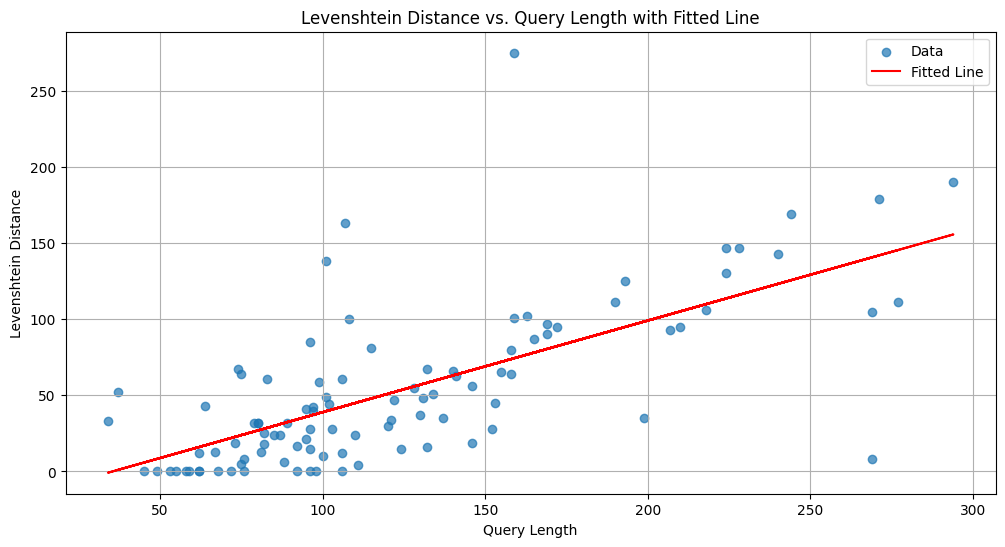

Slope: 0.6019382746859666
Intercept: -21.310539888528453
R-value: 0.6870213888550476
P-value: 2.9692306509672115e-15
Standard error: 0.06431115170822851


In [21]:
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt

query_lengths = [m["query_length"] for m in levenshtein_metrics]
distances = [m["distance"] for m in levenshtein_metrics]

x = query_lengths
y = distances

slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)

def linear_func(x):
    return slope * np.array(x) + intercept

plt.figure(figsize=(12, 6))
plt.scatter(x, y, alpha=0.7, label="Data")
plt.plot(x, linear_func(x), color='red', label="Fitted Line")

plt.title("Levenshtein Distance vs. Query Length with Fitted Line")
plt.xlabel("Query Length")
plt.ylabel("Levenshtein Distance")
plt.legend()
plt.grid(True)
plt.show()

print("Slope:", slope)
print("Intercept:", intercept)
print("R-value:", r_value)
print("P-value:", p_value)
print("Standard error:", std_err)

<Axes: xlabel='query_lengths', ylabel='distances'>

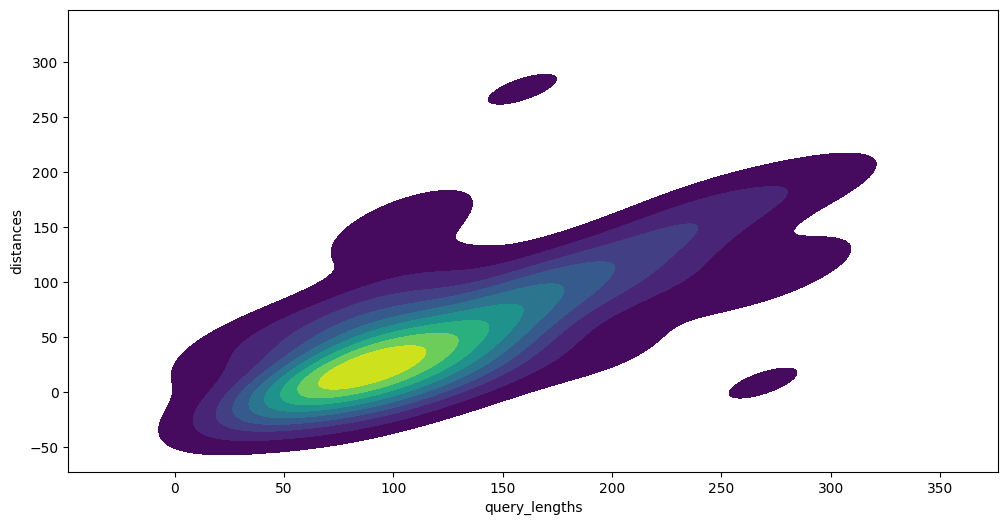

In [20]:
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.kdeplot({"query_lengths": query_lengths, "distances": distances}, x="query_lengths", y="distances", cmap="viridis", fill=True)